In [ ]:
import numpy as np
import pandas as pd

from collections import Counter
from src.utilsRatings import *
from src.utilsGenres import *
from src.utilsWordcloud import *



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mattice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Genres

### Load data

In [501]:
# Load data
processed_movies_df = pd.read_csv("data/processed_movies.csv")
movies_df = processed_movies_df[['Movie name', 'Movie release date', 'Movie genres']]

#### Add a "Periods" column

In [502]:
movies_df_copy = movies_df.copy()
movies_df_copy.loc[:, 'Periods'] = movies_df_copy['Movie release date'].apply(map_year_to_periods, periods=periods_map)

movies_df_copy['Periods'].head(5)

0     [War on Terrorism (2001-present)]
1           [Post-Cold War (1992-2001)]
2        [The Belle Époque (1900-1914)]
3    [The Great Depression (1929-1939)]
4    [The Great Depression (1929-1939)]
Name: Periods, dtype: object

#### Process the "Movie genres" column

- casefold
- transform the string into a list of strings (1 string = 1 genre)


In [486]:
# Casefolding all the strings of column "Movie genres" the Data Frame
movies_df_copy['Movie genres'] = movies_df_copy['Movie genres'].apply(lambda x: x.casefold() if isinstance(x, str) else x)

# Clean the genres
movies_df_copy['Movie genres'] = movies_df_copy['Movie genres'].apply(clean_genres)
movies_df_copy['Movie genres'].head(5)

0    [thriller, science fiction, horror, adventure,...
1     [mystery, biographical film, drama, crime drama]
2    [short film, silent film, indie, black-and-whi...
3                   [musical, comedy, black-and-white]
4                             [drama, black-and-white]
Name: Movie genres, dtype: object

### Add a "Themes" column

- creation of 13 themes: Action/Adventure/Thriller, Comedy, Drama/Mystery, Romance, Horror/Crime, Science Fiction/Fantasy, Animation/Family, Historical/Biographical/Documentary, Short/Silent, Black-and-White, Independent/Experimental/LGBT, Musical, and Other.
- genres are mapped to one or several themes among the 13.

In [487]:
movies_df_copy['Themes'] = movies_df_copy['Movie genres'].apply(lambda genres: map_genres_to_themes(genres, genre_to_theme_mapping))
movies_df_copy['Themes'].head(5)

0    {Horror/Crime, Action/Adventure/Thriller, Othe...
1    {Drama/Mystery, Horror/Crime, Historical/Biogr...
2    {Black-and-White, Independent/Experimental/LGB...
3                   {Black-and-White, Comedy, Musical}
4                     {Drama/Mystery, Black-and-White}
Name: Themes, dtype: object

### Plots

In [488]:
# Prepare the data for the plots
movies_df_copy_exploded = movies_df_copy.explode('Themes')

themes = list(theme_mapping.keys())

# Map themes to distinct colors
theme_colors = {theme: color for theme, color in zip(themes, custom_colors)}

#### Themes according to Years

In [489]:
themes_years_counts = (
    movies_df_copy_exploded
    .groupby(['Themes', 'Movie release date'])
    .size()
    .reset_index(name='count')
)

# Pivot the table so that each theme has its own column
theme_years_counts_pivot = themes_years_counts.pivot(index='Movie release date', columns='Themes', values='count')
theme_years_counts_pivot = theme_years_counts_pivot.fillna(0)

# Normalize the counts
normalized_theme_years_counts = theme_years_counts_pivot.div(theme_years_counts_pivot.sum(axis=1), axis=0)

#### Number of movies over the years

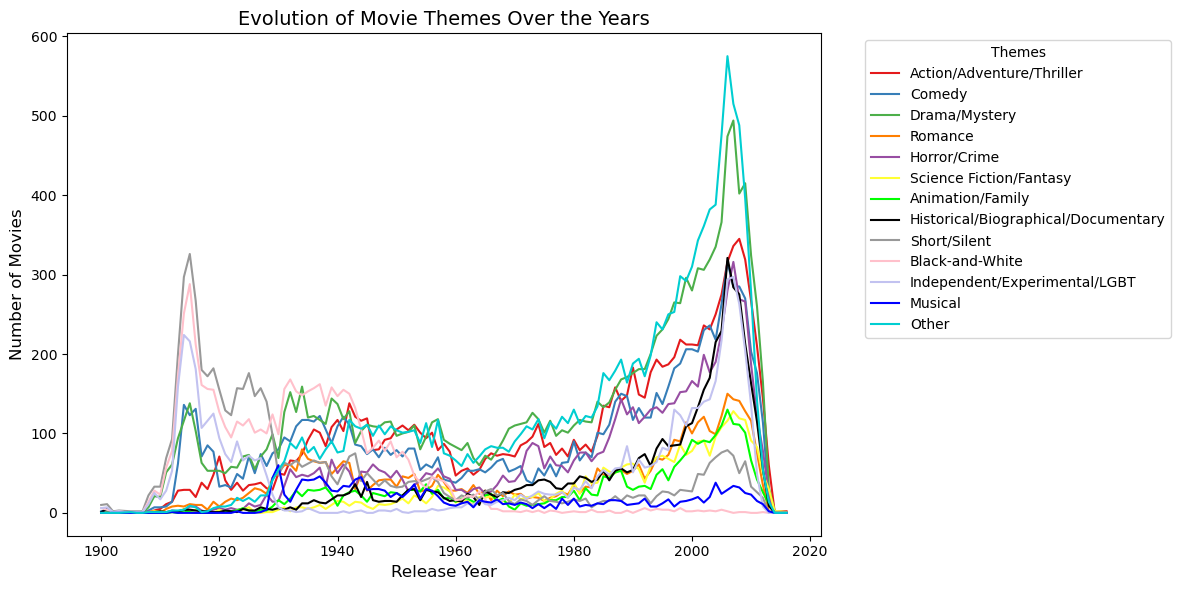

In [ ]:
plot_theme_over_years(theme_years_counts_pivot, themes, theme_colors)

#### Focus on the top firt and last 3 Themes from 1900 to nowadays

Identify the top 3 popular themes from the first and last 10 years of data and generates interactive plots showing the trends of these themes over time, with associated genres displayed on hover.

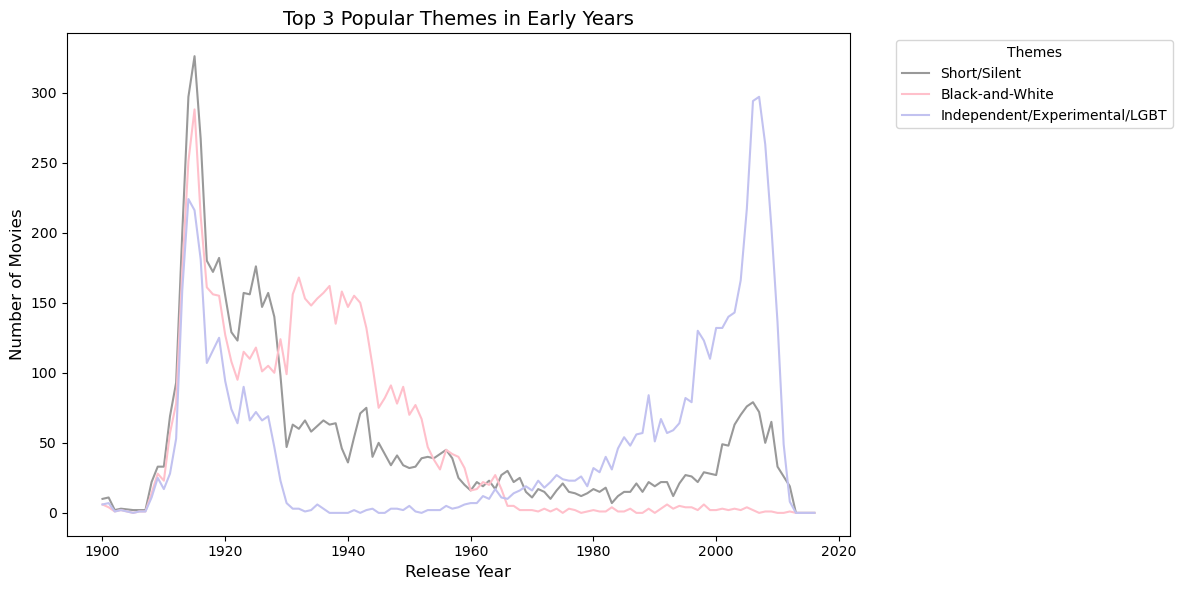

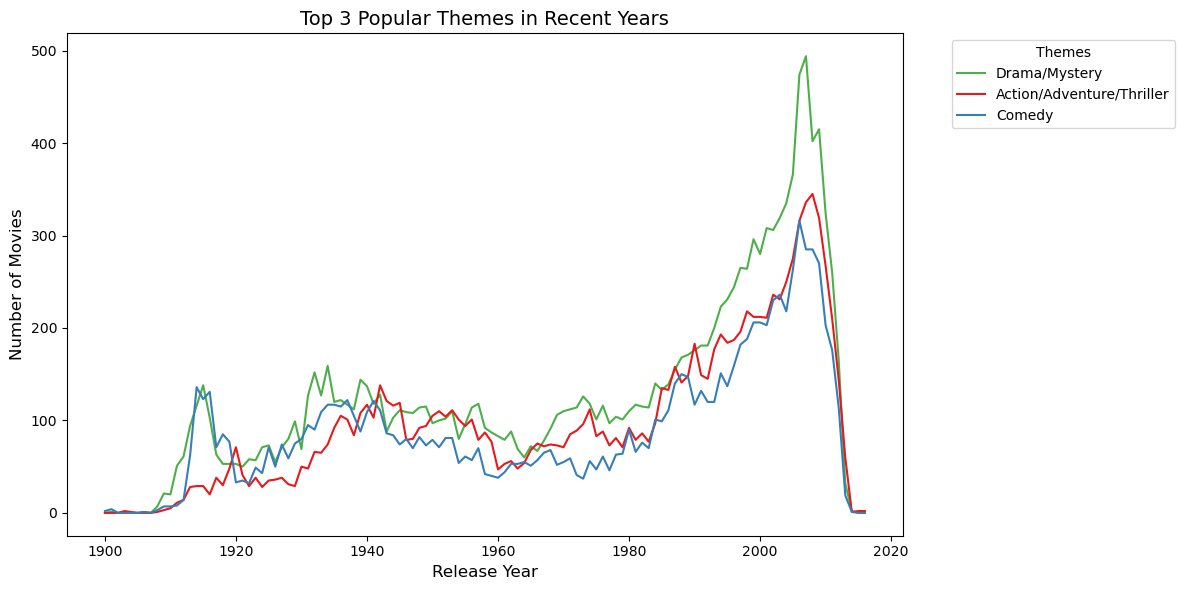

In [491]:
# First 3 most popular themes for the earliest years
start_years = theme_years_counts_pivot.iloc[:10] # based on the first 10 years
start_popular_themes = start_years.sum().nlargest(3).index

# First 3 most popular themes for the most recent years
end_years = theme_years_counts_pivot[theme_years_counts_pivot.columns.difference(['Other'])]
end_years = end_years.iloc[-10:] # based on the last 10 years
end_popular_themes = end_years.sum().nlargest(3).index

plot_top3(theme_years_counts_pivot, start_popular_themes, theme_colors, '/Users/lilly-flore/Desktop/line_start_3.html', "Top 3 Popular Themes in Early Years")
plot_top3(theme_years_counts_pivot, end_popular_themes, theme_colors, '/Users/lilly-flore/Desktop/line_end_3.html', "Top 3 Popular Themes in Recent Years")

#### Themes according to Periods

   - The `movies_df_copy_exploded` DataFrame is created by exploding the `'Periods'` column. This step is necessary since a single movie can belong to multiple periods, and we want to analyze each period separately.

   - We pivot the `themes_counts_periods` DataFrame using the `pivot()` method to create a table where each row represents a period, and each column represents a theme. The values in the table correspond to the count of movies for each theme and period combination.

   - The periods are sorted according to a predefined order stored in `period_order_map_dict`.

   - The pivot table is then normalized row-wise. For each period, the counts are divided by the sum of the counts in that row. The result is a table of percentages, where each value represents the proportion of movies for a particular theme in a given period.

In [344]:
movies_df_copy_exploded = movies_df_copy_exploded.explode('Periods')

themes_counts_periods = (
    movies_df_copy_exploded
    .groupby(['Themes', 'Periods'])
    .size()
    .reset_index(name='count')
)

# Pivot the table so that each theme has its own column
theme_periods_counts_pivot = themes_counts_periods.pivot(index='Periods', columns='Themes', values='count')

sorted_periods = sorted(period_order_map_dict.keys(), key=lambda x: period_order_map_dict[x])

# Reorder the index of the pivot table based on the sorted periods
theme_periods_counts_pivot = theme_periods_counts_pivot.loc[sorted_periods]
theme_periods_counts_pivot = theme_periods_counts_pivot.fillna(0)

# Normalize the counts row-wise to calculate percentages
normalized_theme_periods_counts = theme_periods_counts_pivot.div(theme_periods_counts_pivot.sum(axis=1), axis=0)

# Display the percentage pivot table
normalized_theme_periods_counts.head(5)

Themes                            Action/Adventure/Thriller  Animation/Family  \
Periods                                                                         
The Belle Époque (1900-1914)                       0.038050          0.002378   
World War I (1914-1918)                            0.038002          0.000784   
The Roaring Twenties (1920-1929)                   0.072216          0.005203   
The Great Depression (1929-1939)                   0.097834          0.028922   
World War II (1939-1945)                           0.144234          0.026555   

Themes                            Black-and-White    Comedy  Drama/Mystery  \
Periods                                                                      
The Belle Époque (1900-1914)             0.230678  0.064209       0.152200   
World War I (1914-1918)                  0.239569  0.122037       0.103036   
The Roaring Twenties (1920-1929)         0.203746  0.092820       0.118210   
The Great Depression (1929-1939)         0.191978  0.132468       0.160438   
World War II (1939-1945)                 0.153874  0.120953       0.144416   

Themes                            Historical/Biographical/Documentary  \
Periods                                                                 
The Belle Époque (1900-1914)                                 0.008323   
World War I (1914-1918)                                      0.003134   
The Roaring Twenties (1920-1929)                             0.006243   
The Great Depression (1929-1939)                             0.012735   
World War II (1939-1945)                                     0.032739   

Themes                            Horror/Crime  Indie/Experimental/LGBT  \
Periods                                                                   
The Belle Époque (1900-1914)          0.005945                 0.184899   
World War I (1914-1918)               0.005289                 0.189814   
The Roaring Twenties (1920-1929)      0.016233                 0.133611   
The Great Depression (1929-1939)      0.055225                 0.005713   
World War II (1939-1945)              0.065478                 0.001273   

Themes                             Musical     Other   Romance  \
Periods                                                          
The Belle Époque (1900-1914)      0.000595  0.006540  0.014863   
World War I (1914-1918)           0.000000  0.005681  0.011166   
The Roaring Twenties (1920-1929)  0.001457  0.028512  0.038293   
The Great Depression (1929-1939)  0.048441  0.097715  0.078315   
World War II (1939-1945)          0.043652  0.126228  0.059476   

Themes                            Science Fiction/Fantasy  Short/Silent  
Periods                                                                  
The Belle Époque (1900-1914)                     0.004756      0.286564  
World War I (1914-1918)                          0.002547      0.278942  
The Roaring Twenties (1920-1929)                 0.004579      0.278876  
The Great Depression (1929-1939)                 0.007736      0.082480  
World War II (1939-1945)                         0.014187      0.066933

Display the evolution of themes over the periods

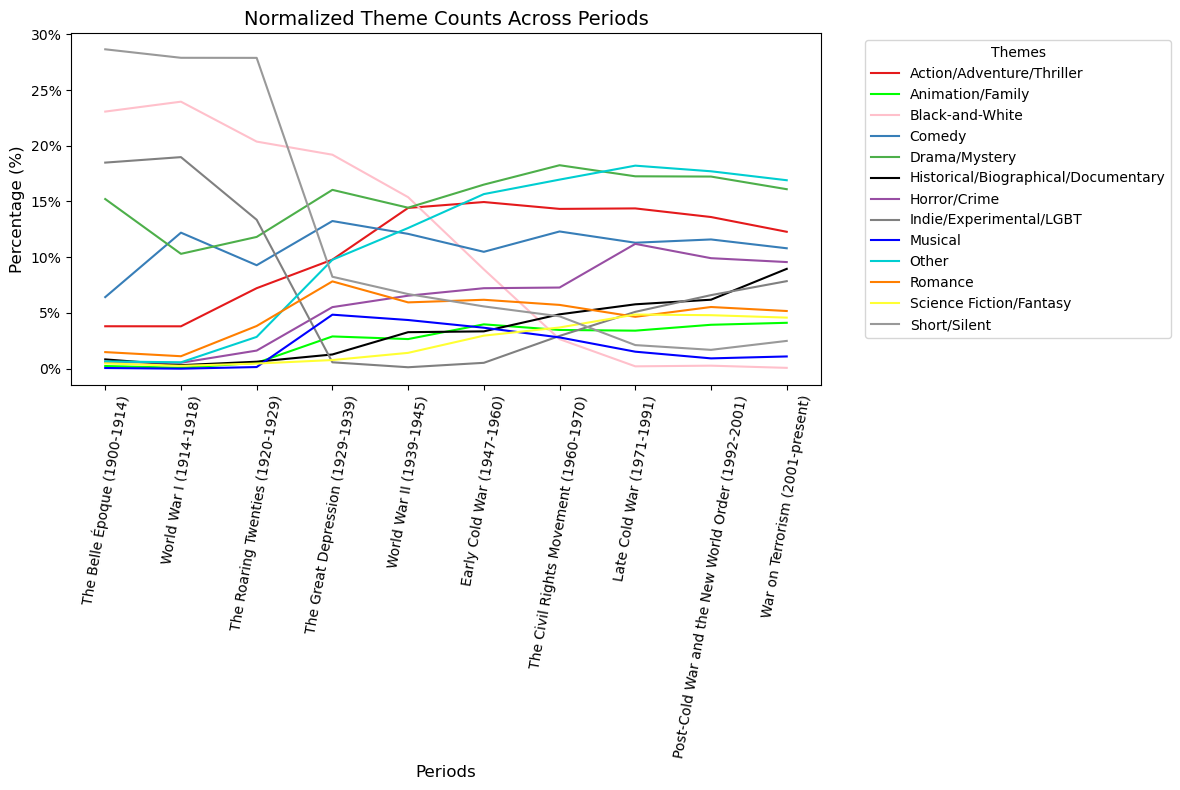

In [528]:
plot_theme_over_periods(normalized_theme_periods_counts, themes, theme_colors)

Interactive stacked bar plot that shows the evolution of movie themes over different periods. It allows users to toggle the visibility of individual themes through a dropdown menu or show all themes at once with a "Show All" button. Each theme is represented by a separate trace, and the plot displays the proportion of movies for each theme per period, with the option to hover over bars to view detailed values.

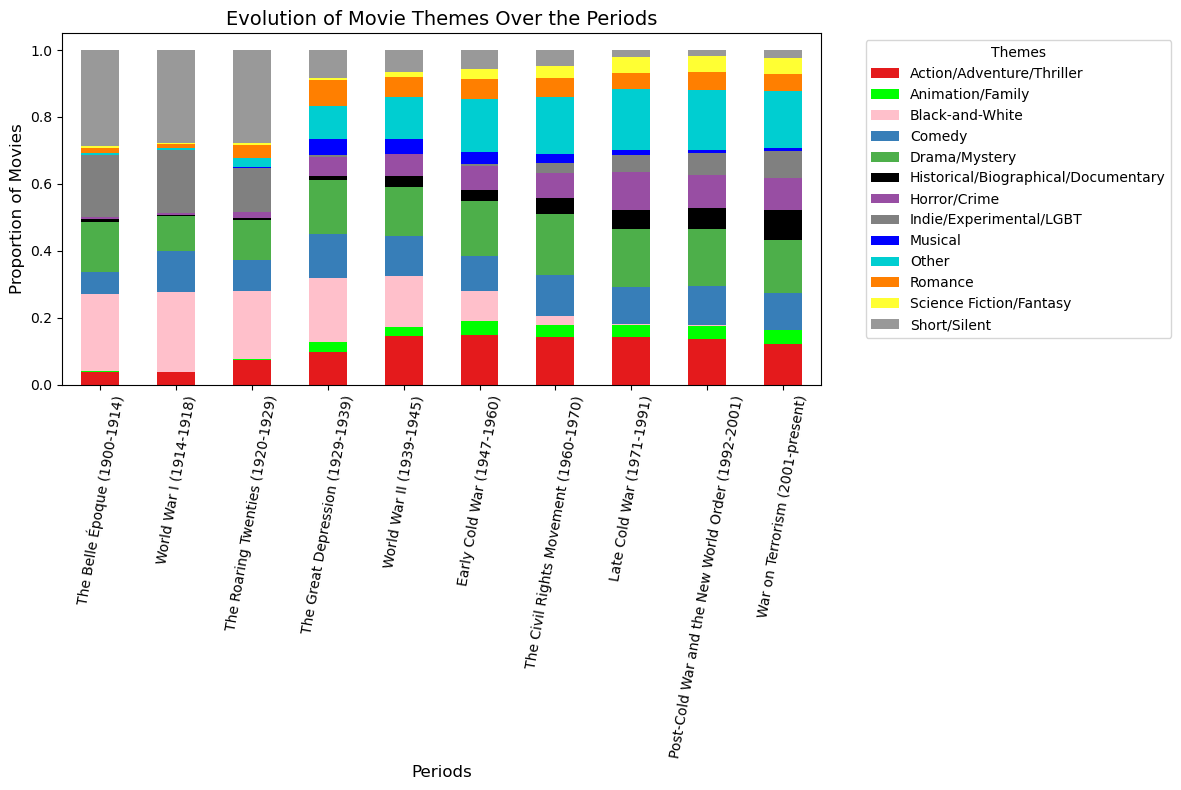

In [526]:
plot_bar_theme_periods(normalized_theme_periods_counts, theme_colors)

This interactive heatmap visualizes correlations between periods, highlighting the top 3 themes contributing to each relationship through hover text.

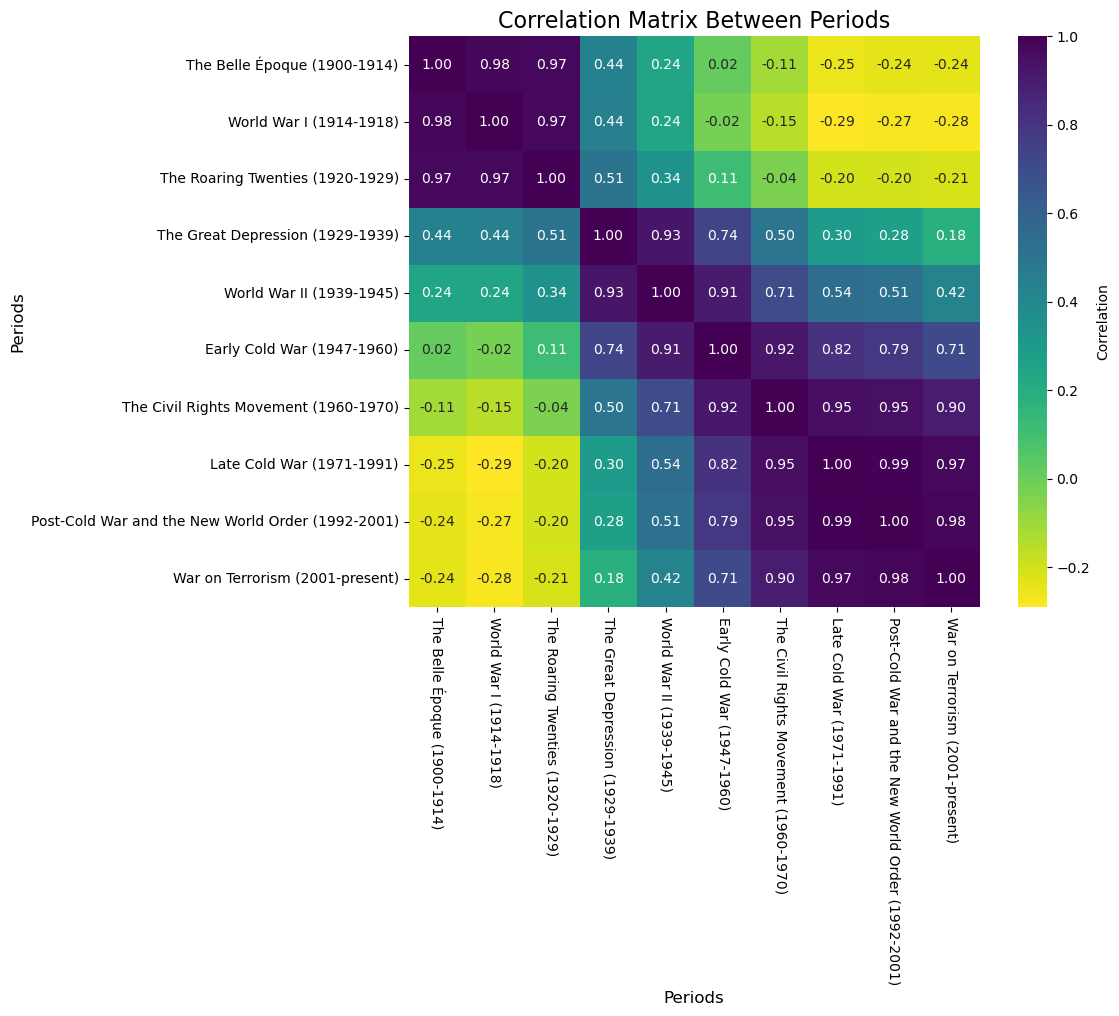

In [494]:
plot_correlation_matrix(normalized_theme_periods_counts)

### Text analysis

Now we can inspect different themes and events through the summaries. 
First we are going to classify arbitraly with some  **tupples {word,weight}** every summary in relation with the periods. 

For this its an die and retry way of doing, maybe not the smartest, to find a treshold , the number of words and the words themselves to classify a summary. 

Everything is a game of balance to see how much to strict we want to be , how many films we want to keep

You can find the list of dictionnary in src/utilsWordcloud.

***The Goal*** here is to have an insight on the summaries. We want to know if there is particularity in the themes through time. Are there common between periods or not ? How can we interpret some topics in relation with real events?

We use the algorythm TF-IDF on these classified summaries to see if we fall back on expected semantics of the targeted subject or not.

Then we also incorporate LDA analysis to see if some topics are shared between periods.

We can also check manually for outliers or errors in data/processed_plot_summaries_classified_yes.csv

In [13]:
filtered_csv_path = "/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv"

**Only some principal examples and not the 10 periods were put to not surchage the notebook with similar plots of results**

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 52


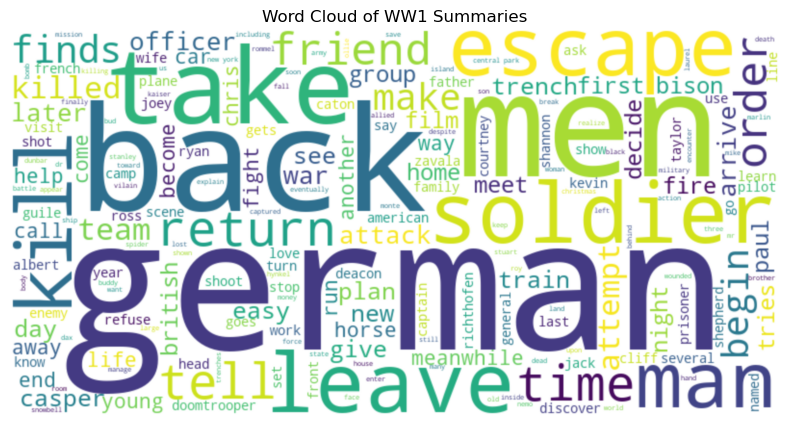

Topic 1: german, soldiers, french, war, men, man, new, escape, central, world
Topic 2: team, ross, shepherd, footage, buddy, kaiser, sub, fort, monte, roy
Topic 3: doomtrooper, dax, hynkel, footage, ice, schultz, mireau, hannah, barber, broulard
Topic 4: stanley, gus, rosie, gnorga, lieutenant, turned, fellow, company, commander, prepares
Topic 5: kevin, courtney, ollie, bison, guile, stan, scott, bisons, brand, pair
Topic 6: hatch, garber, nelson, mike, seaview, sheryl, ida, hijackers, blue, couple
Topic 7: dunbar, spongebob, taylor, joey, zavala, snowbell, stuart, horse, albert, invasion
Topic 8: rommel, richthofen, paul, charlotte, caton, kte, japanese, von, kat, mcclosky
Topic 9: swann, vilain, nemo, benjy, paul, marlin, dory, expendables, kemmerich, kaiser
Topic 10: clouseau, easy, ryan, deacon, beth, sinclair, cliff, rob, rocket, gould
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [12]:
analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=ww1_keywords,
    synonyms=synonyms,
    threshold=7,name = "WW1"
)

The topics found with Latent dirichlet allocation can be very variable and not telling a lot as it often group names or places together making the analyis between period a bit complex 

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 25


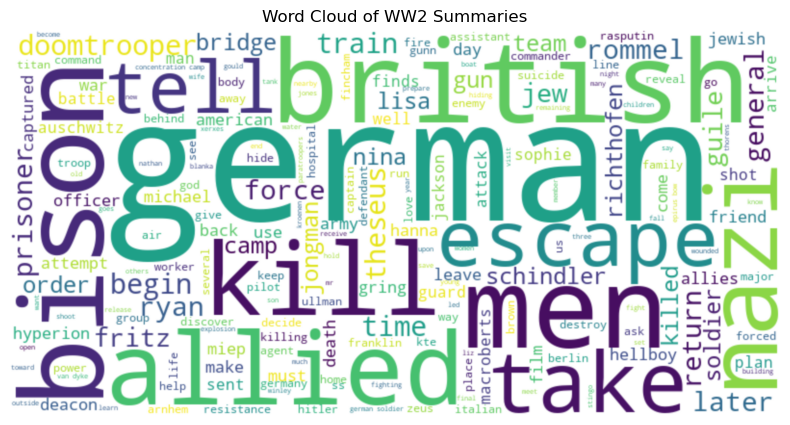

Topic 1: rommel, michael, miep, theseus, guile, bison, children, mr, hanna, auschwitz
Topic 2: island, patrol, message, allied, successful, landing, frank, information, alive, french
Topic 3: doomtrooper, gring, jackson, team, malloy, speer, gilbert, crimes, jones, german
Topic 4: taking, situation, killed, arrives, death, eventually, away, meets, later, forced
Topic 5: richthofen, ryan, train, kte, von, fincham, voss, italian, brown, prisoners
Topic 6: schindler, gunn, water, factory, jews, germans, goeth, workers, schindlers, stern
Topic 7: jongman, van, lisa, dyke, prisoners, mallory, franklin, auschwitz, leatherby, guns
Topic 8: macroberts, arnhem, general, bridge, paratroopers, british, bartlett, xxx, browning, men
Topic 9: sophie, stingo, nathan, children, camp, father, make, auschwitz, sent, gestapo
Topic 10: hellboy, nina, deacon, fritz, xerxes, leonidas, rasputin, allies, right, winley
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/

In [17]:

analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=ww2_keywords,
    synonyms=synonyms,
    threshold=7,name="WW2"
)

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 200


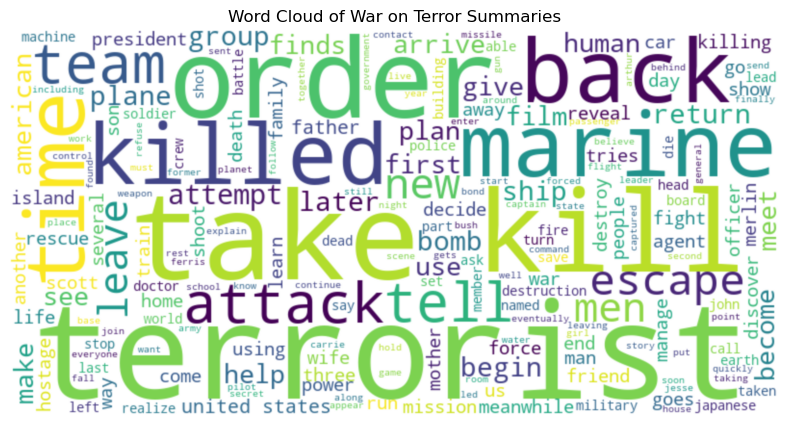

Topic 1: stark, village, company, events, wounded, missile, building, device, weapons, rescued
Topic 2: ryback, colony, harry, sarah, doctor, interview, village, anthony, ships, train
Topic 3: terrorist, terrorists, bomb, group, new, time, world, wife, dr, home
Topic 4: garber, hassan, cris, saigo, held, want, escapes, ferris, terrorists, terrorist
Topic 5: craig, pike, doctor, anthony, merlin, ryder, stavros, goodspeed, quinn, mason
Topic 6: marines, team, president, plane, japanese, war, men, united, states, mission
Topic 7: bob, stone, izzy, harold, caton, matrix, village, tell, situation, start
Topic 8: village, caspian, jesse, ferris, carrie, edy, anna, sarah, stone, light
Topic 9: bridger, faraday, arthur, jonn, ferris, harry, centre, doctor, quinn, anthony
Topic 10: kong, cabot, oskar, cavil, sarge, reaper, 11, intelligence, working, leader
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


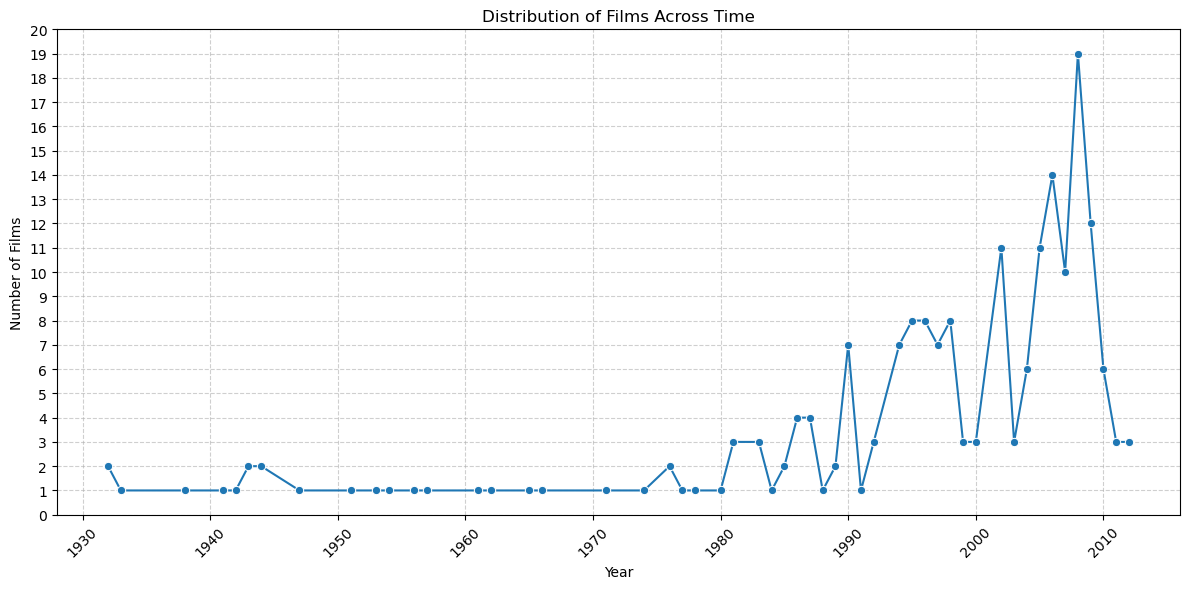

Summary statistics for film years:
count     200.000000
mean     1994.480000
std        18.076043
min      1932.000000
25%      1990.000000
50%      2000.000000
75%      2007.000000
max      2012.000000
Name: Year, dtype: float64


In [ ]:
analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=W991_keywords,
    synonyms=synonyms,
    threshold=7,name="War on Terror"
)
# this function is used to analyze the time distribution of the movies per period 
analyze_time_distribution(filtered_csv_path)

As we see terrorism film obsivously rise after 2001 attacks in New York but were already a theme in cinema and not necessarily linked to a period as we see for other periods. Films treating of terrorism can be classified as belonging to our traget period while they have nothing to do there. These outliers can be removed manually by inspection or just kept depending of the analysis we want to perform

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 41


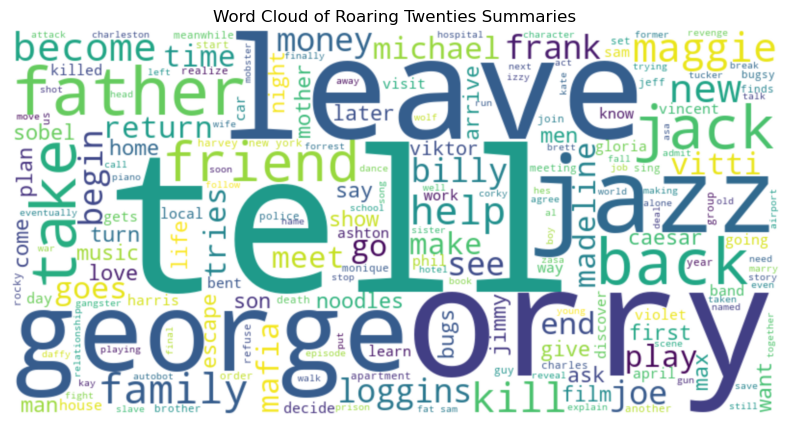

Topic 1: jack, mafia, joe, frank, father, new, tells, charleston, max, family
Topic 2: izzy, autobots, allspark, celia, sam, love, musical, producer, van, horn
Topic 3: tucker, billy, phyllis, automobile, dream, company, helps, makes, airport, secret
Topic 4: loggins, bugs, wolf, forrest, rakes, rocky, daffy, harris, mugsy, monique
Topic 5: viktor, finch, george, april, owl, morgan, explains, airport, horn, dixon
Topic 6: noodles, punisher, joe, scene, jazz, quickly, say, hit, player, playing
Topic 7: harvey, jeff, fat, jazz, orleans, guy, bugsy, plot, mafia, faye
Topic 8: owl, sing, instead, jazz, young, gang, german, seen, best, plot
Topic 9: michael, caesar, vincent, violet, corky, zasa, johnnie, gino, altobello, mary
Topic 10: kate, jazz, maggie, vitti, mike, orry, sobel, club, know, tony
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [18]:
analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=Roaring,
    synonyms=synonyms,
    threshold=16,name="Roaring Twenties"
)

Again even if the dictionnary was very precised we have a lot of noise on the TF-IDF wordclouds results and not necessary useful data (this was an expected behaviour from the tf-idf algo). Howver some elements of the topics do indeed link us semantically to that period

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 204


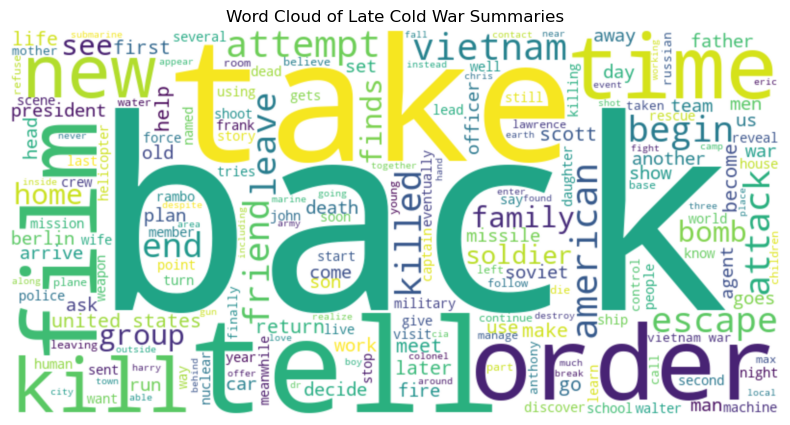

Topic 1: kate, bourne, eric, daniel, miyagi, karl, scott, informs, river, mike
Topic 2: bozz, caldwell, austin, driver, window, lost, member, lawrence, learn, squad
Topic 3: rambo, billy, jake, river, lost, college, fall, station, stay, bar
Topic 4: general, veteran, hunt, gang, lawrence, george, terminator, richie, terrorists, kyle
Topic 5: scott, murtaugh, ralph, arrive, general, driver, heads, learn, window, college
Topic 6: max, anthony, cris, leatherface, helen, eric, heads, window, arrive, george
Topic 7: taylor, viet, cong, squad, platoon, mac, village, enemy, sergeant, heads
Topic 8: frank, van, dominic, mike, otto, chris, walter, drug, vietnam, veteran
Topic 9: alien, novel, bond, station, main, kate, computer, submarine, rest, squad
Topic 10: vietnam, nuclear, war, film, american, new, vietnamese, states, president, bomb
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


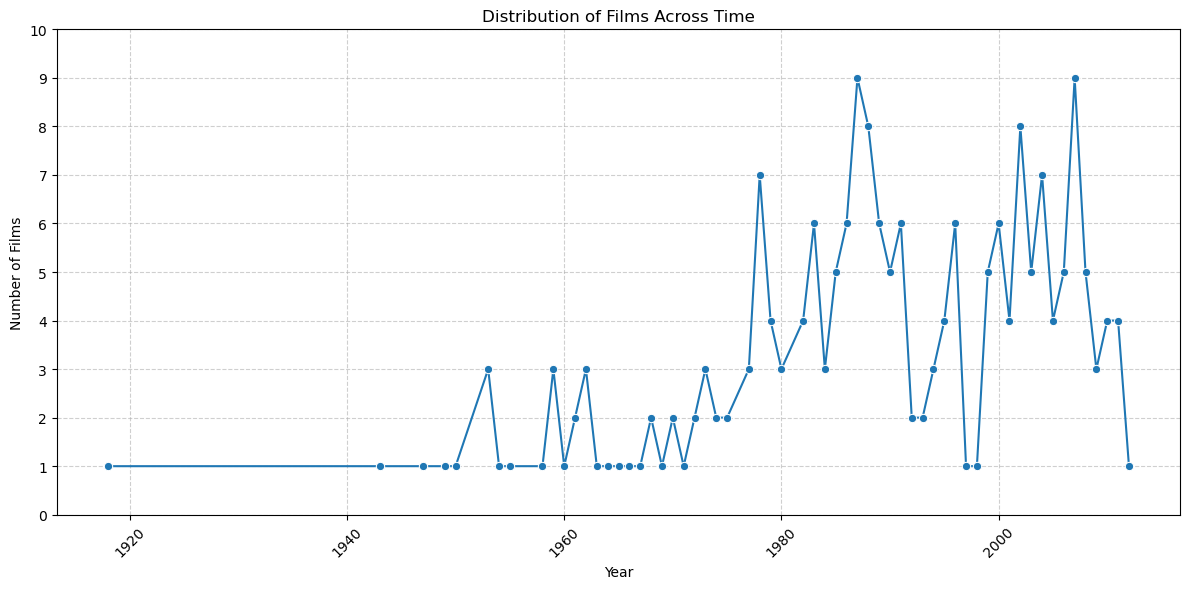

Summary statistics for film years:
count     204.000000
mean     1988.166667
std        16.532448
min      1918.000000
25%      1979.000000
50%      1989.000000
75%      2002.000000
max      2012.000000
Name: Year, dtype: float64


In [19]:
analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict = LateColdWar,
    synonyms=synonyms,
    threshold=16,name="Late Cold War"
)
analyze_time_distribution(filtered_csv_path)

Here for the late cold war we have a good matching text classification-period with some outliers that nothing to do in the 50's. However we see the cinematographic interest of this period where american went to war in vietnam and political crisis between the US and URSS was at there best. Cinematography was a way to diffuse soft power for America

## Results from this part correspond to the section focusing on Ratings in the website

We decided to use ratings instea dof box office in this section, beacause the box office data was 90% missing (can be seen in src/datapreprocessing), and ratings are close to all present. Using ratings, and linking it to previous themes and analysis made sense for us, as the number of movies that come out each year, gives a certain idea of a genre popularity, but not directly the public's appreciation of genres. Also we wanted to see how old movies age, and made a focus on the movies featured in the top 100 list of the American Film Institude (https://www.afi.com/afis-100-years-100-movies-10th-anniversary-edition/), as the movies in that list are supposed to be very highly rated.  
All functions used in this part are in src/utilsRatings.py.

In [1]:
from src.utilsRatings import *

mov = pd.read_csv("data/processed_movies.csv")
# Movies with and without rating
# no_rat stands for no_rating, i.e. all movies with a missing rating entry or number of votes entry
no_rat = mov[mov['averageRating'].isnull() | mov['numVotes'].isnull()]
# rat stands for rating, i.e. all movies with a valid rating entry and number of votes entry
rat = mov[mov['averageRating'].notnull() & mov['numVotes'].notnull()]

We first started by dividing our dataset in the movies that have a rating, and thoise that do not, to avoid any problems with nan values later. We will baerly use no_rat (standing for no_rating) in later parts, but first start by looking at the number of movies having a missing rating

In [ ]:
RatingsNbrOfMovies(rat, no_rat)

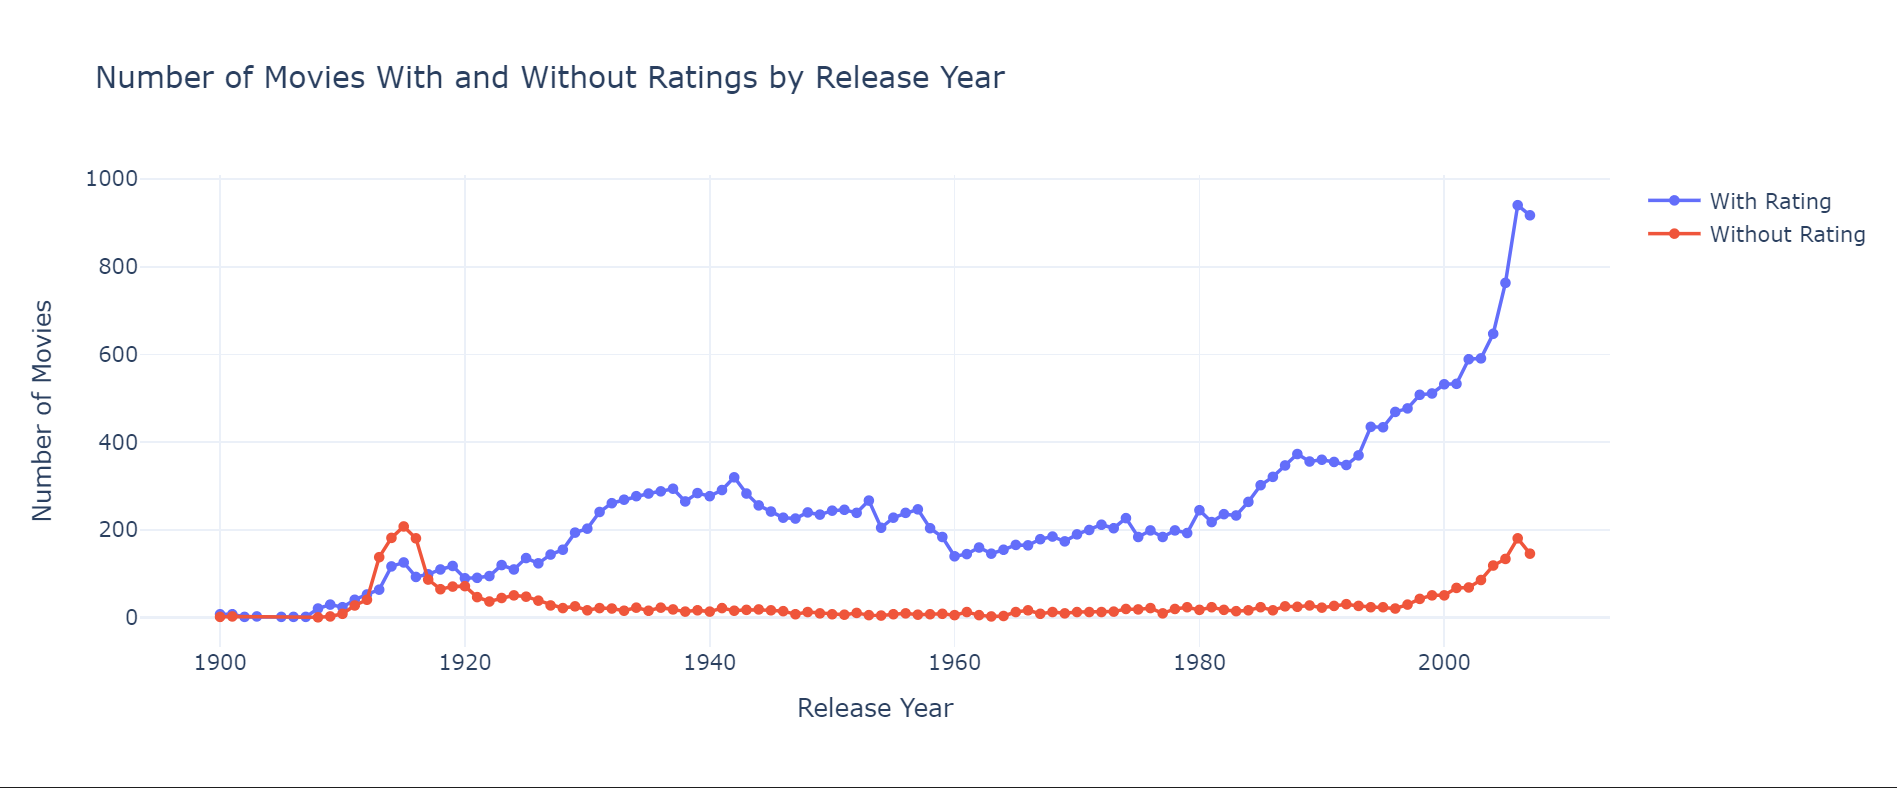

We can see that there are a lot of movies without rating for years between 1912 and 1918 and later on around 2007. The first peak of missing ratings is quite problematic as there are more movies without rating than with, while the second is much less problematic since there are more movies that have a rating. 
We should take this into account later on when trying to draw conclusions about very old movies from before the 20s.  
We've seen that we have more movies with a rating coming out in later years (just because there are more movies coming out as seen previously), but we want to also see if the number of votes keep increasing. People having easier access to websites such as imndb should make the number of votes go up. 


In [ ]:
RatingsVsYearsAllPlotly(rat)

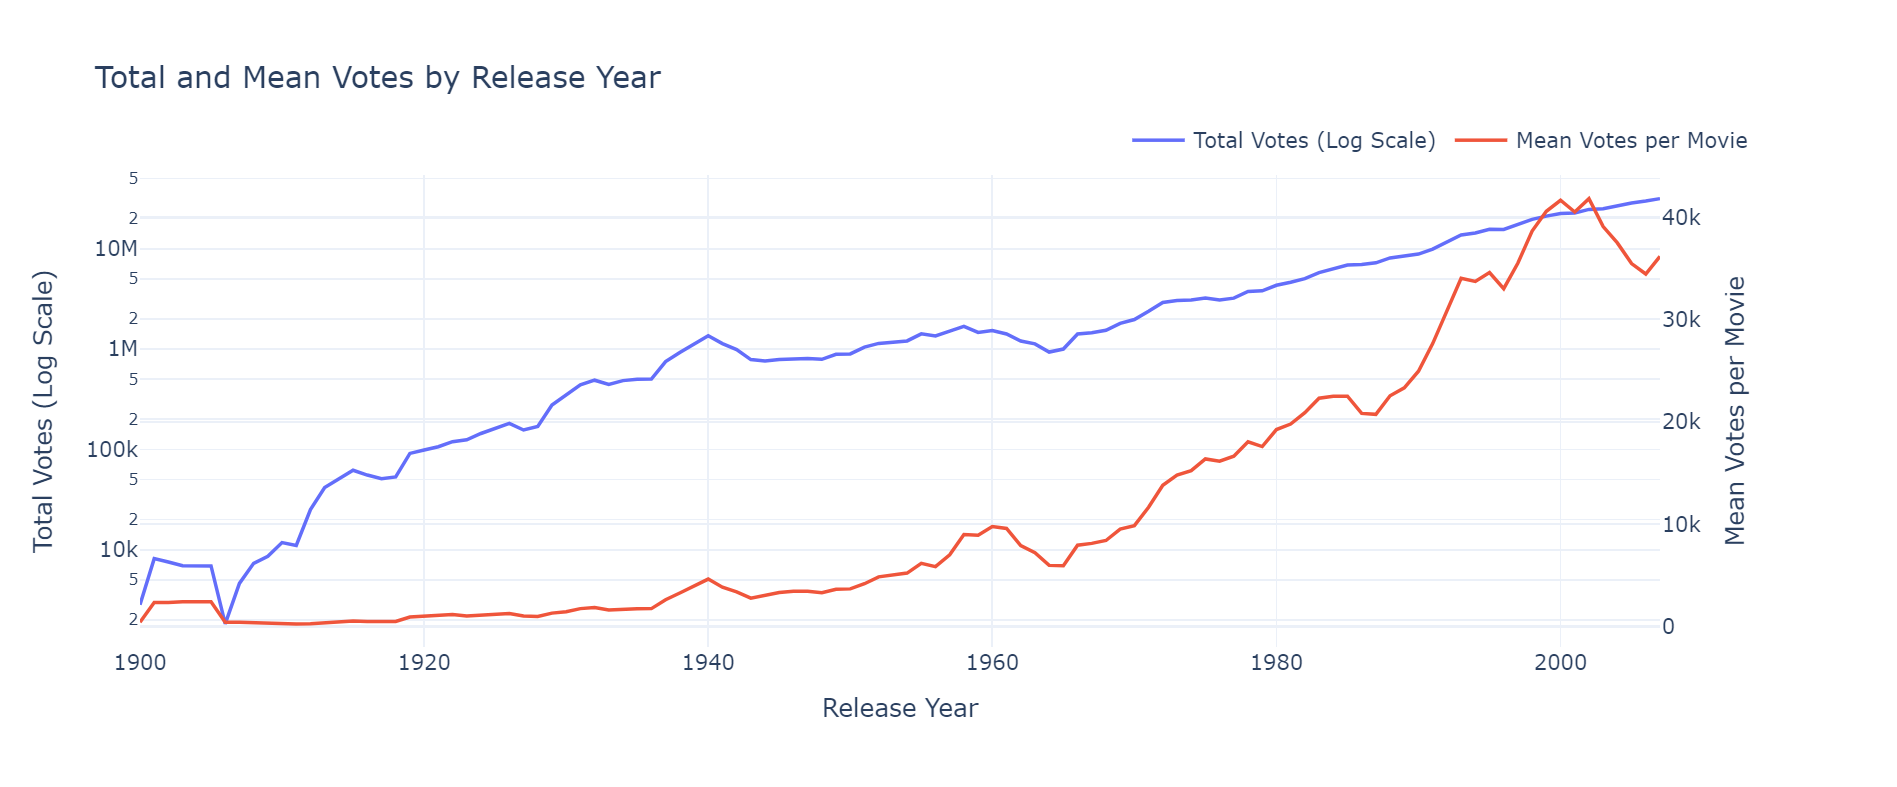

Indeed, the number of votes are exponentially bigger nowadays (notice the log scale), and even the average number of votes per movie is going up. Meaning that even though there are more movies coming out now than before, more people watch and rate these movies.

Now we switch to another point of interest, we want to vizualize the ratings for each year. We first only plotted the nextr graph using the mean rating with error bars, but it was not really informative, as the mean rating is quite stable, and has huge error. Here we made the assumption that a movie with more votes is more famous, which for us is reasonable. So we thought about computing the weigted rating. A movie's average rating is multiplied with it's average rating (which is more or less the same as adding all the individual ratings for a movie), and then we add up all the weighted ratings from a year and divide by the total number of votes that year. This metric should be more informative, as an unkown movie with only 10 votes should not have the same weight as one with a million votes. 

In [ ]:
RatingsWithErrorBarsPlotly(rat)

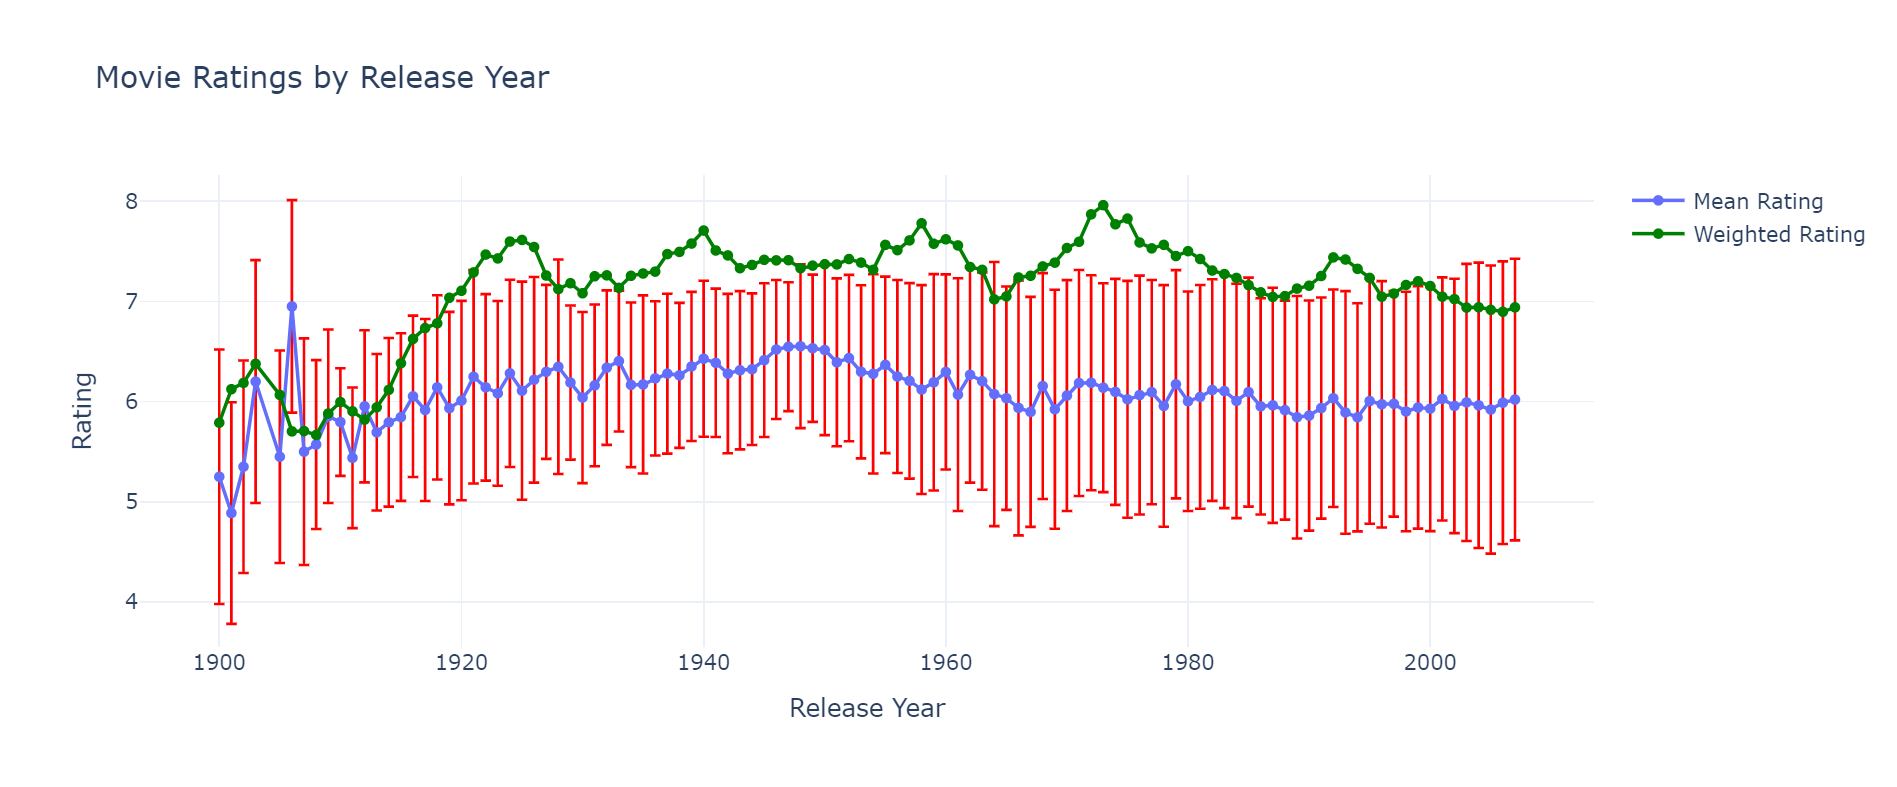

Indeeed the result is flagrant: the mean and weighted ratings are really separate. This probably means that movies with a high number of votes, tend to have a higher rating as well, because they make the weighted rating go up significally. Knowing that, we thought about computing correlation metrics, notably the Pearson for linearity, and Spearman for non-linearity coefficients. To get a better understanding, we computed these coefficients on all the whole dataset, on the years that stands out the most on our plot: 1973, and we also computed the min and maximum correlation coefficients. 

In [2]:
pearson_corr_all, spearman_corr_all = computePearsonSpearmanCorr(rat, year=None)
pearson_corr_1973, spearman_corr_1973 = computePearsonSpearmanCorr(rat, year=1973)
print(f"Pearson correlation (all data): {pearson_corr_all}")
print(f"Spearman correlation (all data): {spearman_corr_all}")
print(f"Pearson correlation (1973): {pearson_corr_1973}")
print(f"Spearman correlation (1973): {spearman_corr_1973}")

max_p, max_s, max_y = 0,0,0
min_p, min_s, min_y = 0,0,0

for year in range(1920,2008):
    p,s = computePearsonSpearmanCorr(rat, year=year)
    if (s > max_s):
        max_p,max_s,max_y = p,s,year
    if (s < min_s):
        min_p, min_s, min_y = p,s,year


print(f"Max Pearson correlation ({max_y}): {max_p}")
print(f"Max Spearman correlation ({max_y}): {max_s}")
print(f"Min Pearson correlation ({min_y}): {min_p}")
print(f"Min Spearman correlation ({min_y}): {min_s}")

Pearson correlation (all data): 0.20417286675453206
Spearman correlation (all data): 0.13748496100686738
Pearson correlation (1973): 0.3789457475348089
Spearman correlation (1973): 0.4912244874859843
Max Pearson correlation (1949): 0.43672606113232776
Max Spearman correlation (1949): 0.6310749464411852
Min Pearson correlation (2006): 0.19723496322779943
Min Spearman correlation (2006): -0.07592210951086635


In [ ]:

# Plot the correlations with customized colors
plot_correlations(pearson_corr_all, spearman_corr_all, pearson_corr_1973, spearman_corr_1973, max_p, max_s, max_y, min_p, min_s, min_y)

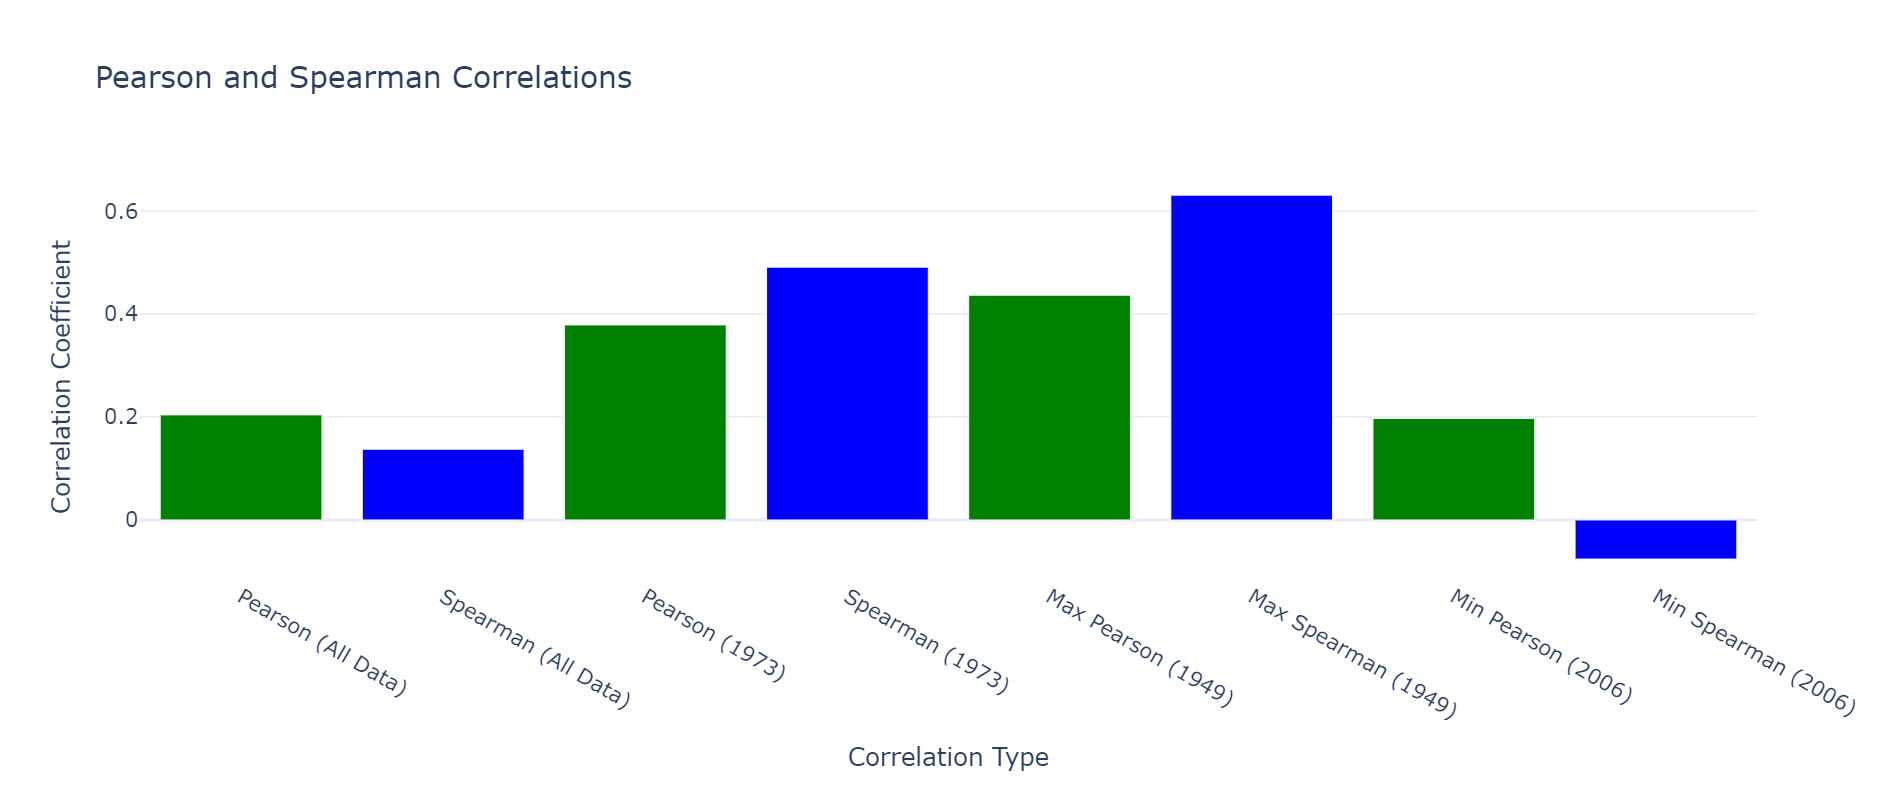

Indeed the correlation in 1973 is higher than on averge on all the data. Also it seems there is oe year (1949) that is extremely correlated and 2006 seems very badly correlated, even having a negative spearsman corr coefficient. We also notice that for 1973 and 1949, the spearman correlation is higher than pearson. This makes us think that there is a non-linear relationship between the rating and the number of votes.  
The easiest to vizualize correlation, especially between two variable sis to plot them on x and y respectively on a scatter plot. We fgirst started using a normal plot, but clearly saw that it would not work:

In [ ]:
RatingsvsVotesScatterLog(rat, frac=0.2, nolog=True)
RatingsvsVotesScatterLog(rat, frac=0.2, nolog=False)

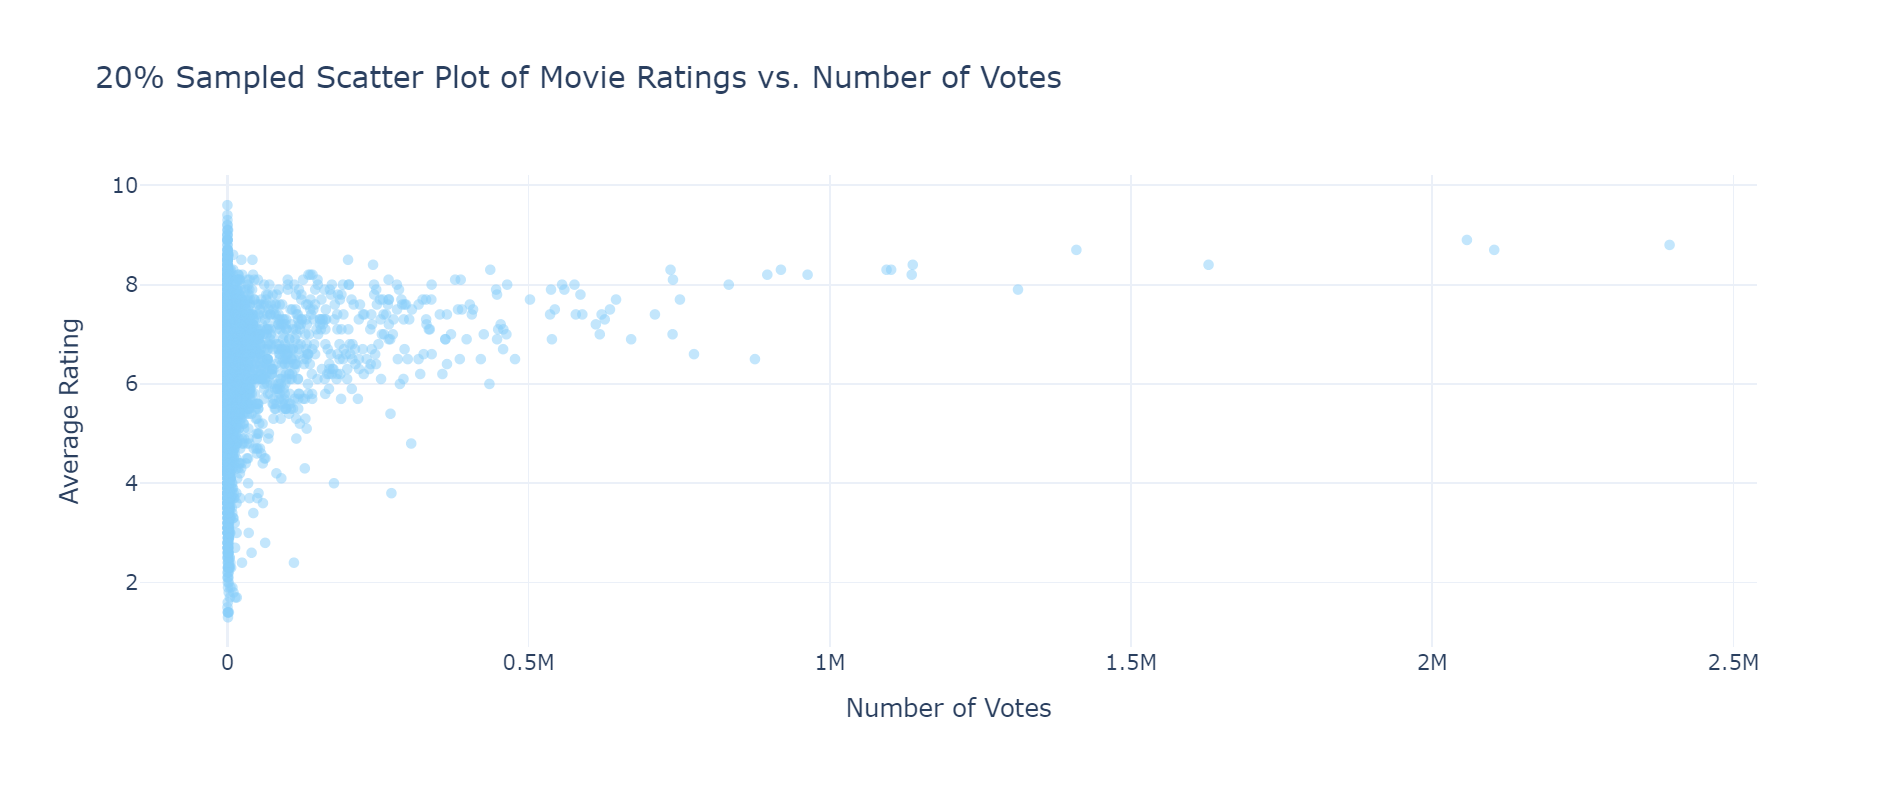
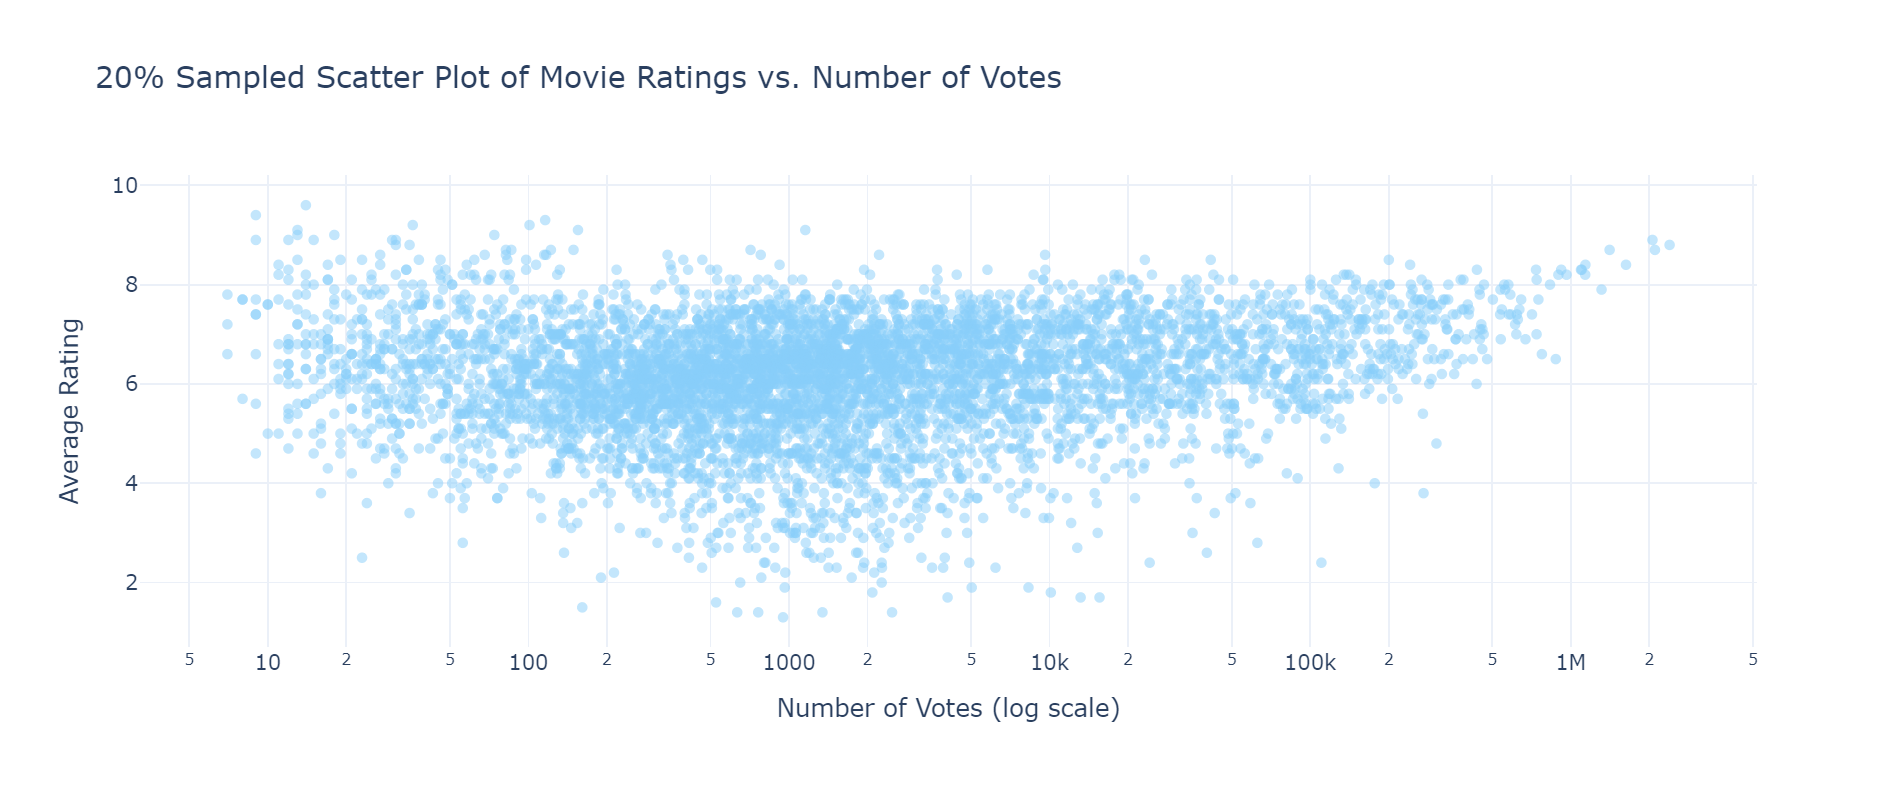

Indeed, the first plot is not really useful. Indeed, we saw it before already when looking at the number of votes for each year, and they increase exponetially. We instantly though about using a log-scale for the number of votes, because the dataset has movies with number of votes between 10 and 2.5 millions. We really like the second plot with log scale because it gives us we think a lot of data, even before filtering the data in function of a single year. We can see that the shape very vaguely resembles a convex polynomial of degree 2, and initially we plotted polynomials on our plots. However, we decided to abandon this idea in the end, because first the polynomial's R^2 score was not excellent, and since we are using the log scale, a degree 2 polynomial is really hard to interpret. However we already have llots of useful information, such as the fact that with higher number of votes (>100k), the ratings eems to go back up. Our interpretation would be that it comes from the fact that if a movies has a bad rating, the audience is less likely to watch it, and thus bad movies do not get a lot of votes apart from the first ones, which classified the movie as a bad movie. This is especially visible in the "belly" shape of the curve between 500 and 5k votes, where most of the "bad movies" reside. For the rest, it seems the best movies, are those with a very low amopunt of votes, but these are more outliers than really significant. Most of them are unkown movies, that came out long ago and no-one ever watched them apart from the few critics of their time. 


Now we want to comne back to the years we mentioned before: 1973, 1949 and 2006, and plot only the movies of these years. Since 1949 has the biggest spearman coefficient, we except it to look very correlated, and 2006 should not look correlated in any way.

In [ ]:

#To filter for specific years, pass a list of years, for example:
RatingsvsVotesScatterYears(rat, frac=1, years=[1949, 1973, 2006])


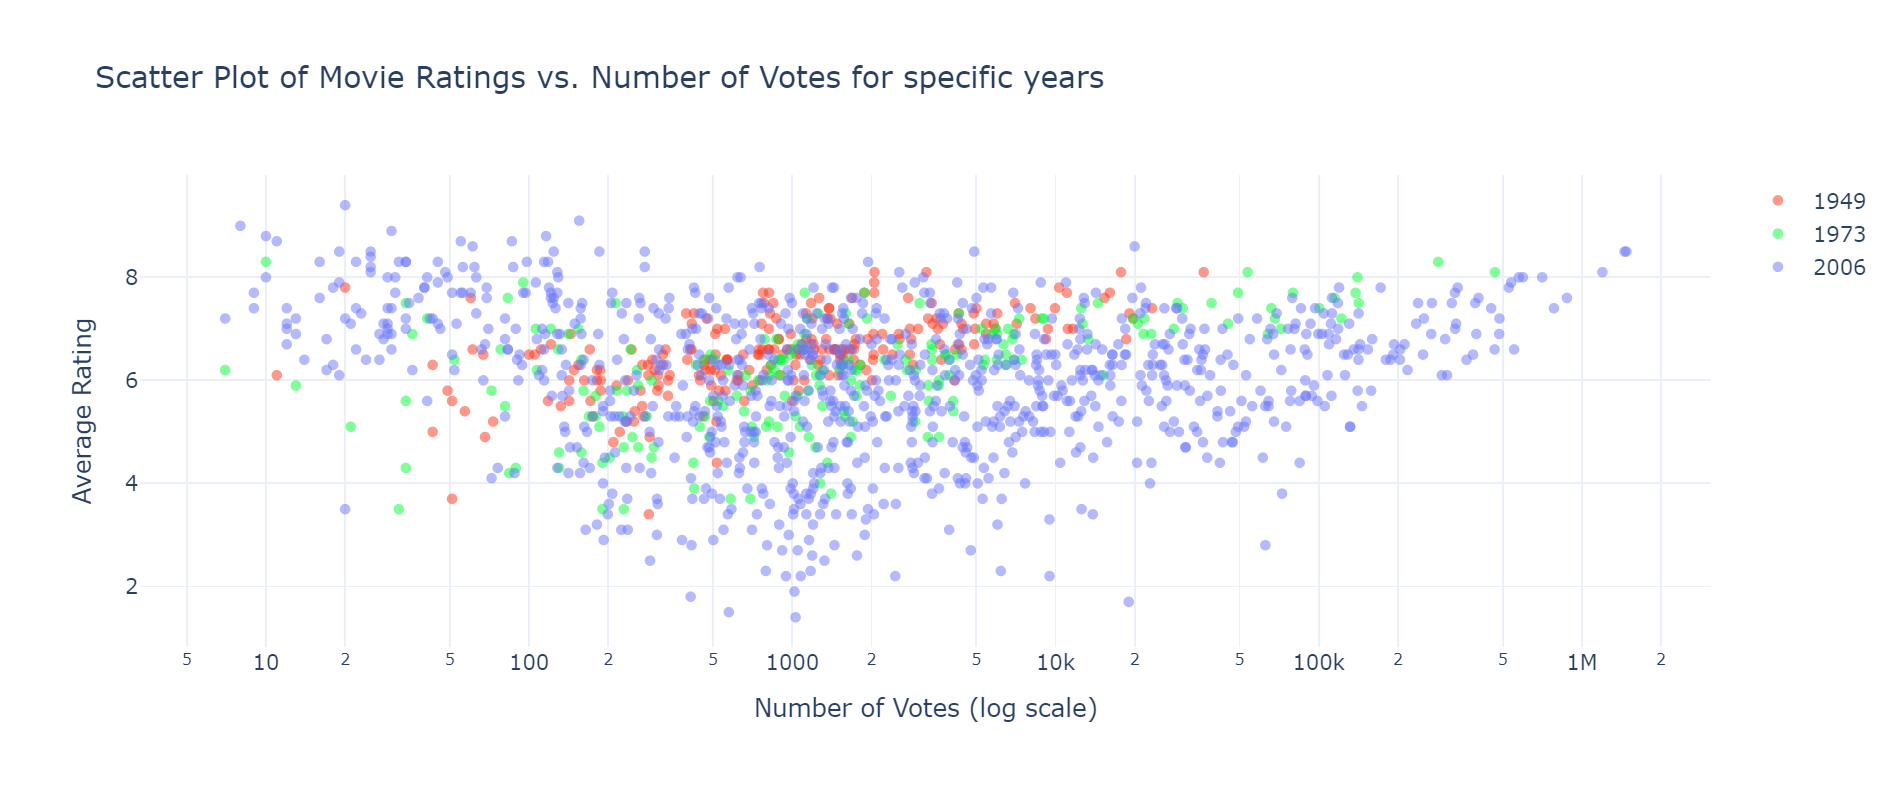

Indeed our assomptions are not too bad. The 1949 movies are very close to a straight line, but since this is a log-scale plot, this does not mean that that the pearson correlation is high, but the spearman coefficeint, which captures monitonic correlation. In this case, the correlation seems to be logarithmic. 1973 follows a similar distribution, but noisier, which explains why the correlation is lower. Also the difference between 1949 and 1973 is the fact that 1973 has more movies above 20k votes, which are all pretty good in terms of rating. This explains why he weighted rating of that years was so high. 2006 on the other side, is very noisy, and has a lot of movies with a rating under 6 and more votes than 5k, which drags the weighed rating down. (In the website these plots are interactive, and we can disable 2006 for easier comparison between 1949 and 1973) 

In [ ]:
def assign_period(year):
    for period, bounds in periods_map.items():
        if bounds["start_year"] <= year <= bounds["end_year"]:
            return period
    return None

# Add a 'Period' column to the DataFrame
rat.loc[:, 'Period'] = rat['Movie release date'].apply(assign_period)

In this part, we came back to our datastory idea, of dividing movies into periods. However the results are not really significant nd interesting. The website being already quite full, we decide to not incorporate the next two plots in the website. 

What we wanted to do was to compare periods, and this would be done by first computing the average and weighted rating for periods (by grouping together all movies of a period) and then selecting two periods that had significantly different ratings to see if any difference arises. In the next plot we an see that the ratings are quite stable, and the only periods with a bad rating are the first ones, but as we've seen before it's also the ones with the least data, so it would be a bd idea to focus on them. We decided to compare Early and Late cold war, because they differ enough for the analysis to be significant. 

In [ ]:
# Usage example
avg_rating_per_period, std_rating_per_period, weighted_avg_rating_per_period = compute_average_ratings_per_period(rat)
plot_ratings_per_period(avg_rating_per_period, std_rating_per_period, weighted_avg_rating_per_period, periods_map)

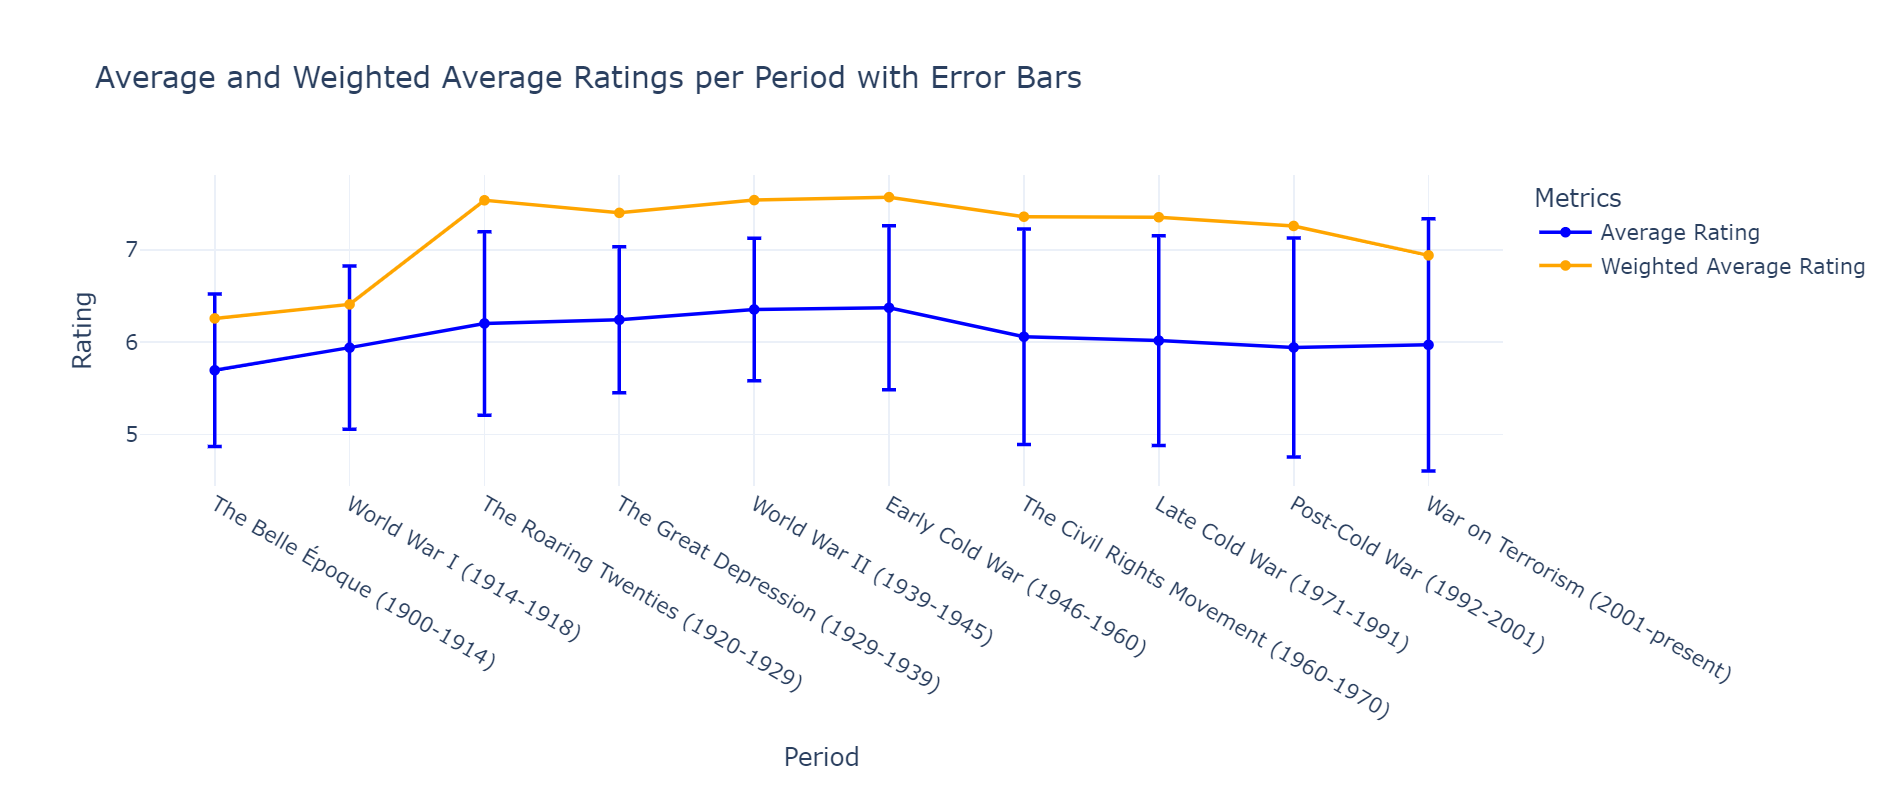

Here we plotted the two mentioned periods, and we see the same difference as before appearing: the period with a lower average and weighted rating has more movies in the lower right part of the graph, which explains why the rating is lower. Again, if this was on the website, we could turn on and off different periods and compare them directly. 

In [ ]:
# To filter for specific years, pass a list of years, for example:
RatingsvsVotesScatter(rat, 0.2, ["Early Cold War (1946-1960)","Late Cold War (1971-1991)"], periods_map)

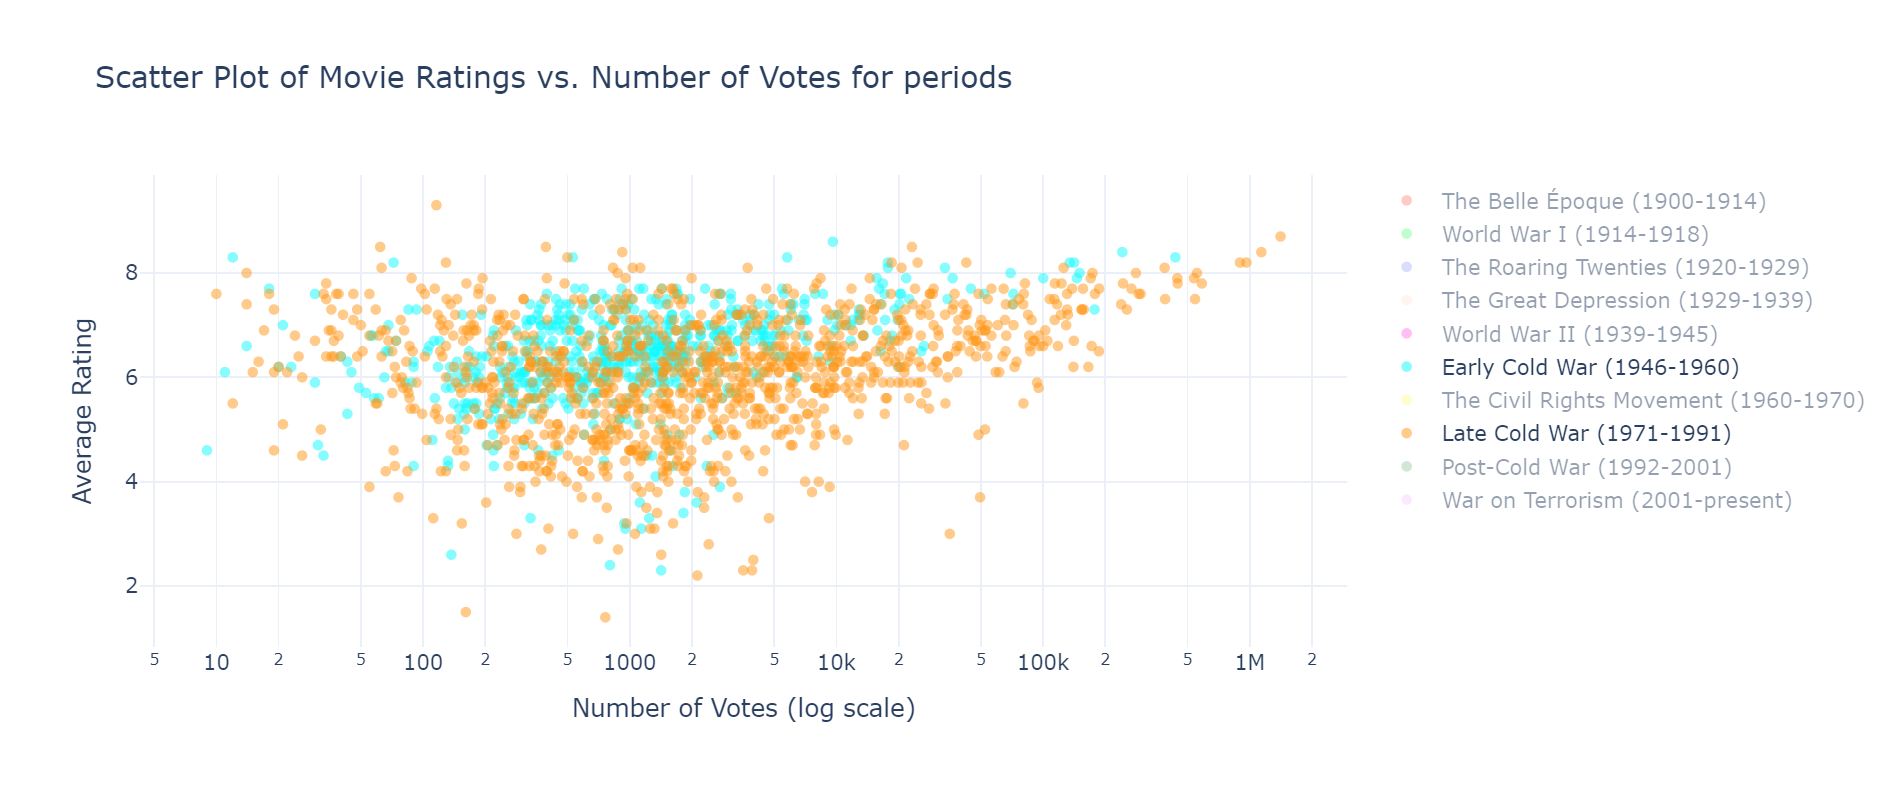

In [ ]:
# Inverting the theme_mapping to map genres to themes
genre_to_theme_mapping = {
    genre: theme
    for theme, genres in theme_mapping.items()
    for genre in genres
}


# Casefolding all the strings of column "Movie genres" the Data Frame
rat.loc[:,'Movie genres'] = rat['Movie genres'].apply(lambda x: x.casefold() if isinstance(x, str) else x)
# Clean the genres
rat.loc[:,'Movie genres'] = rat['Movie genres'].apply(clean_genres)
# Map Genres
rat.loc[:,'Themes'] = rat['Movie genres'].apply(lambda genres: map_genres_to_themes(genres, genre_to_theme_mapping))


Now back to the Themes. We have already spoken quite a biut about themes before, but it was always about the number of moives, and not about the rating. So to also get a second view on those we wanted to see if certain themes were significantly better than others. We first start with the "early" themes, and watch if there is anything particular. We also plotted the weighted average per period, to have a point of comparison. If a theme is "overperfoming", it should be above the average of that period. 

In [ ]:
# Usage example
# To exclude schindler's list use rat[~rat["Movie name"].str.strip().__eq__("Schindler's List")]
weighted_avg_ratings = compute_weighted_ratings_per_theme_period(rat, periods_map)
plot_weighted_ratings_by_theme(weighted_avg_ratings,weighted_avg_rating_per_period, periods_map,True,showByDefault=['Independent/Experimental/LGBT', 'Black-and-White', 'Short/Silent'])

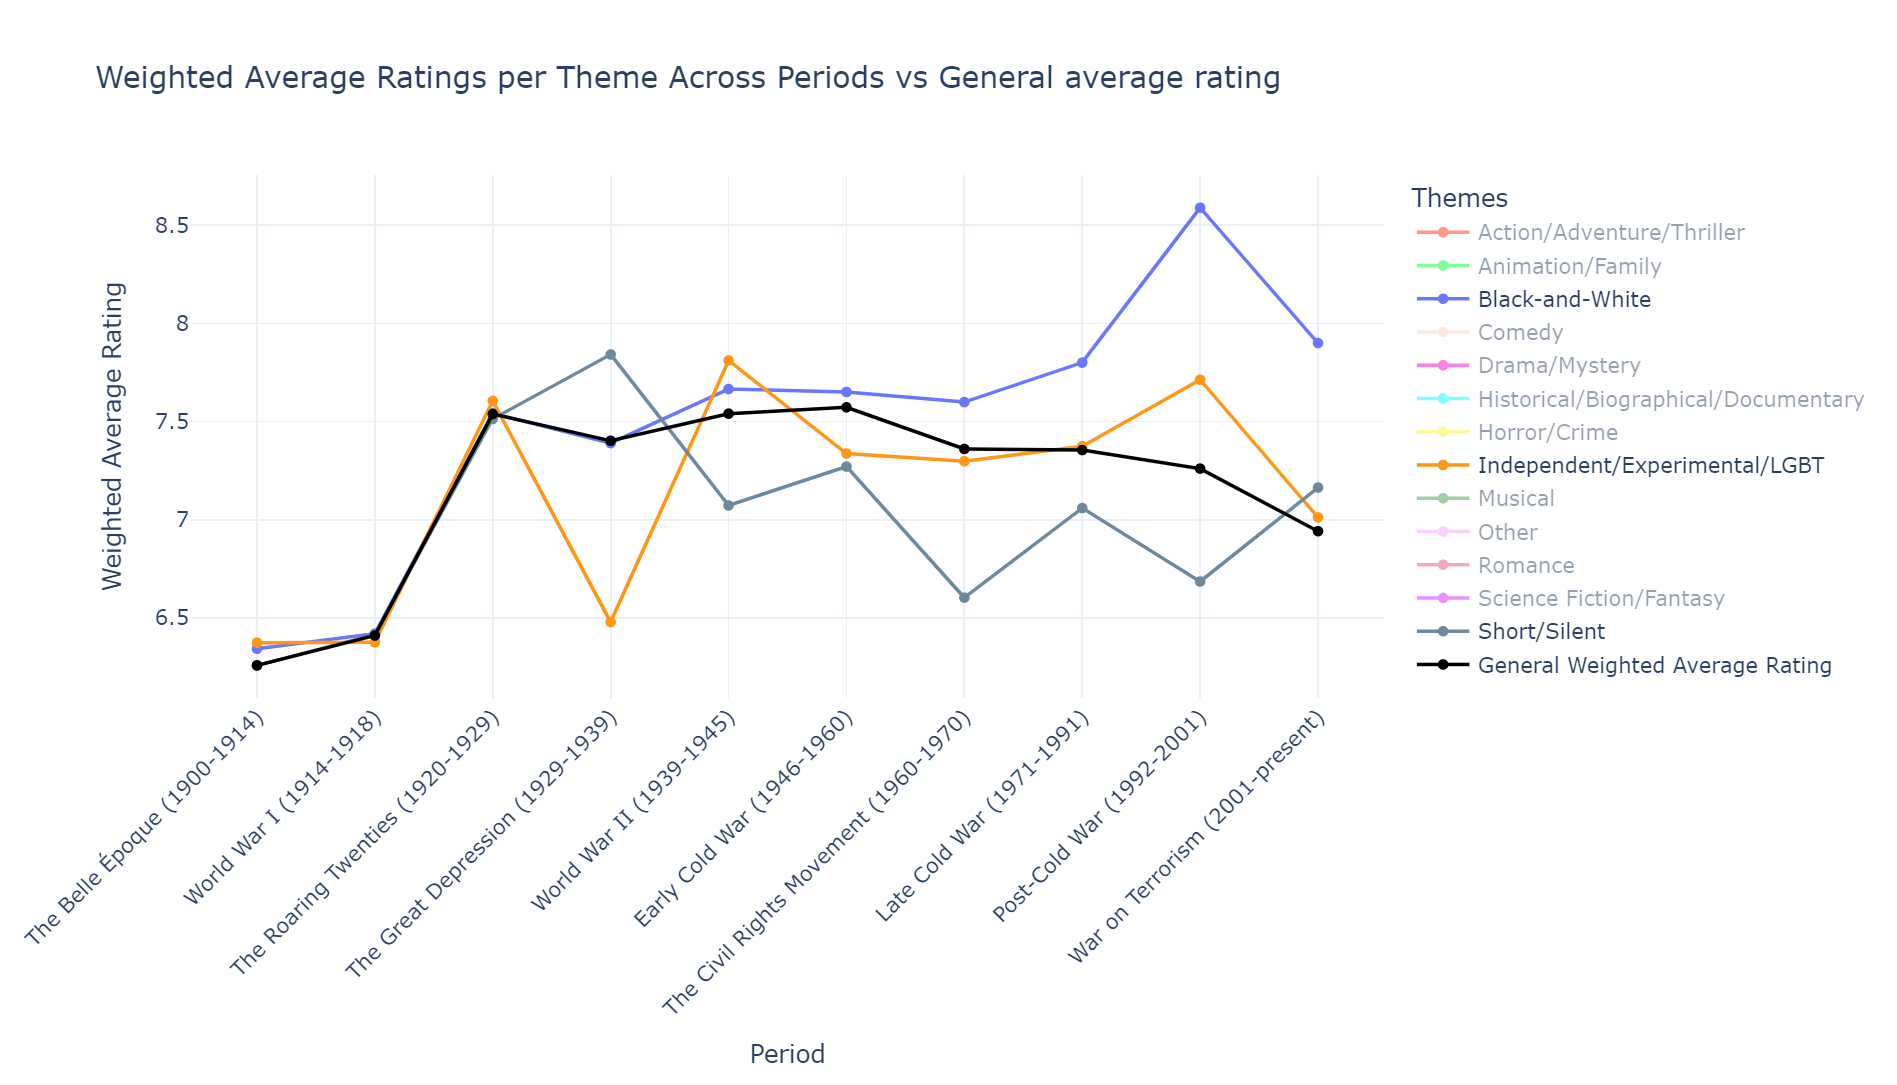

Indeed there is something very weird going on, the Black-and-White ratings are very high compared to the average of that period (7.2). We are data investigators, so we decided to look into it, and for good measure compare it to the worst result visible in the plot: Independent movies in The Great Dperession.

In [ ]:
# Example Usage
selected_pairs = [
    ("Black-and-White", "Post-Cold War (1992-2001)"),
    ("Independent/Experimental/LGBT", "The Great Depression (1929-1939)")
]
RatingsvsVotesByThemePeriod(rat, selected_pairs, True,frac=1)

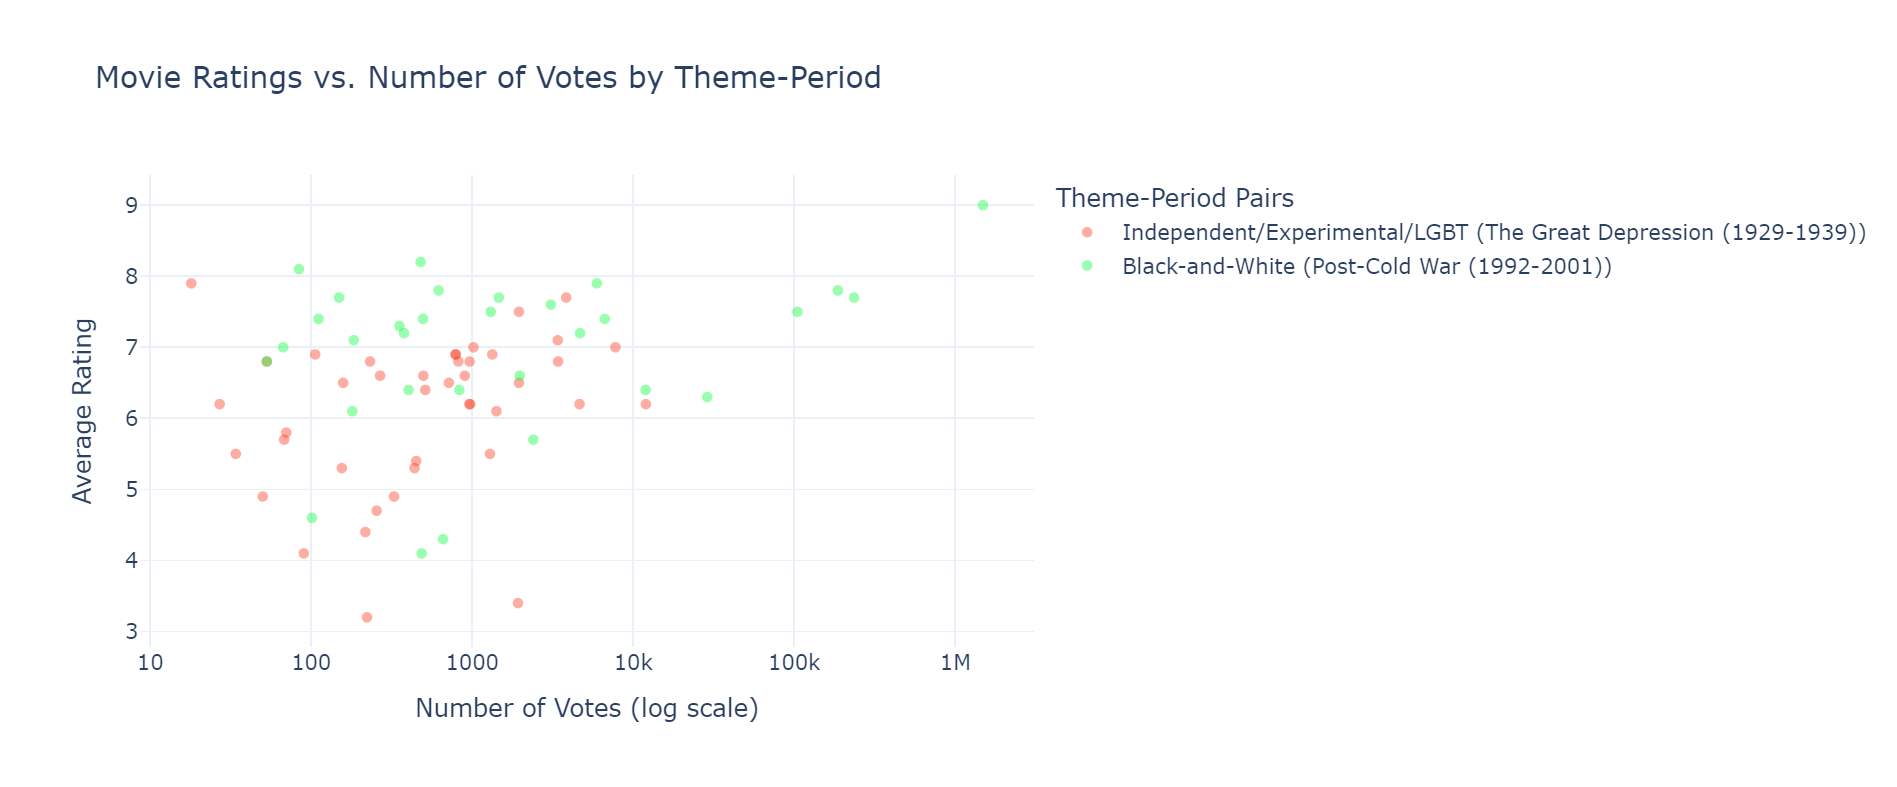

It does not work here, as we made the plots static in casse the dynamic ones would not load on the grader's computer (but it works in the webiste, check it out!), but the movie on the top-right corner is Schindler's List. Since it has a very high rating and nbr of votes, it significally shiftes the weighted average. So in this case, it's more of an outlier than a something to analyse. What we can note though, is that this movie did something exceptional in a period where it was not common to get these kind of scores.

Then we go back to the 3 main genre of the recent years: Action, Drama, and Comedy. Looking a bit into AFI's list (cited above), we can see that most movies in this top 100 are Drama movies, and more importantly, they are all old (came out before 1980s for the most ones). So we would like to compare these themes, again regrouped on periods to make the plots less noisy as multiple years are grouped. 

In [ ]:
weighted_avg_ratings = compute_weighted_ratings_per_theme_period(rat, periods_map)
plot_weighted_ratings_by_theme(weighted_avg_ratings,weighted_avg_rating_per_period, periods_map,False,showByDefault=['Action/Adventure/Thriller', 'Comedy', 'Drama/Mystery'])

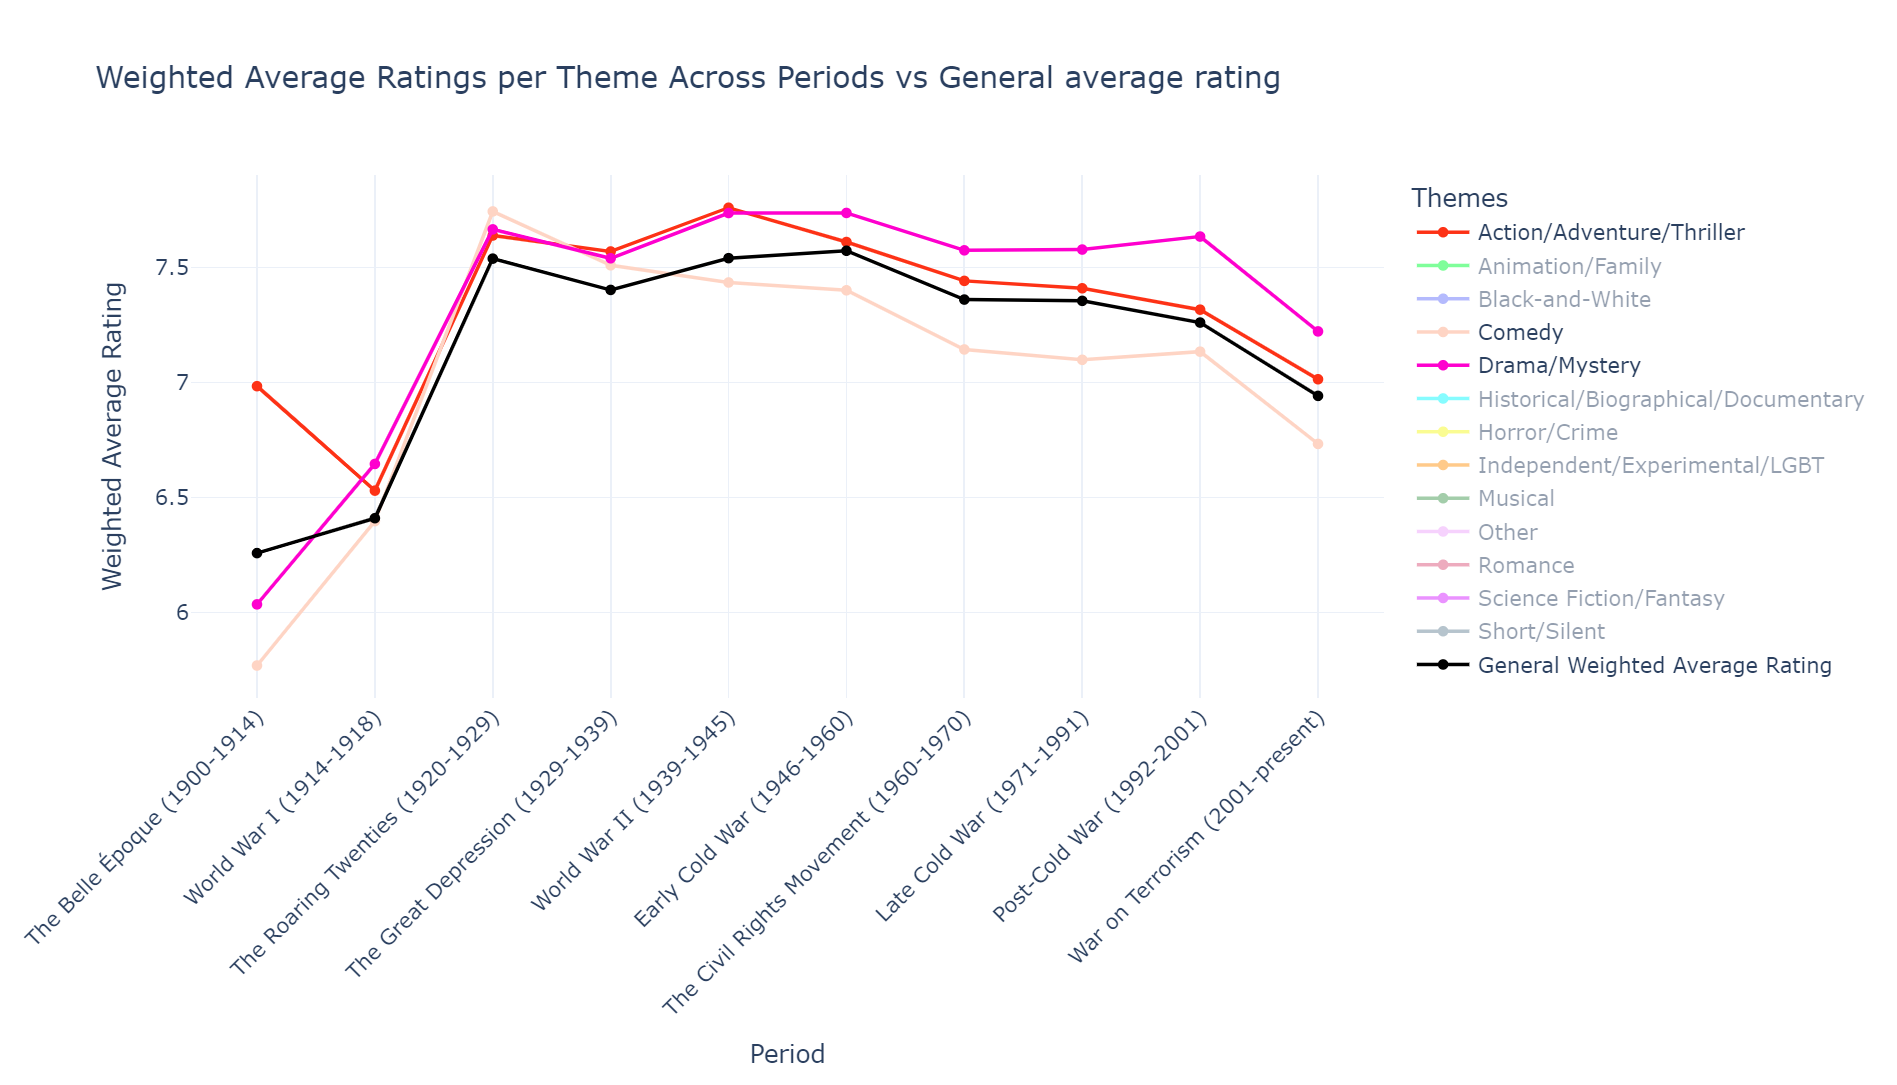

On this plot we can indeed see that Drama movies seem to always be overperforming, and Comedy alsways underperforming (at least since WW2). That might give a slight insight why the AFI's list mostly has Dramas, as they are better than other genres (on average). On the other hand, Action movies seem to be very stable, following the mean closely. Another thing to notice is the decline of all genres in the recent years, which was already visible before in the plot with only periods. We decide to plot two periods to compare comedies and Drama movies at different timepoints

In [ ]:
# Example Usage
selected_pairs = [
        ("Comedy", "Late Cold War (1971-1991)")
,
    ("Drama/Mystery", "World War II (1939-1945)")
]

RatingsvsVotesByThemePeriod(rat, selected_pairs, False,frac=1)

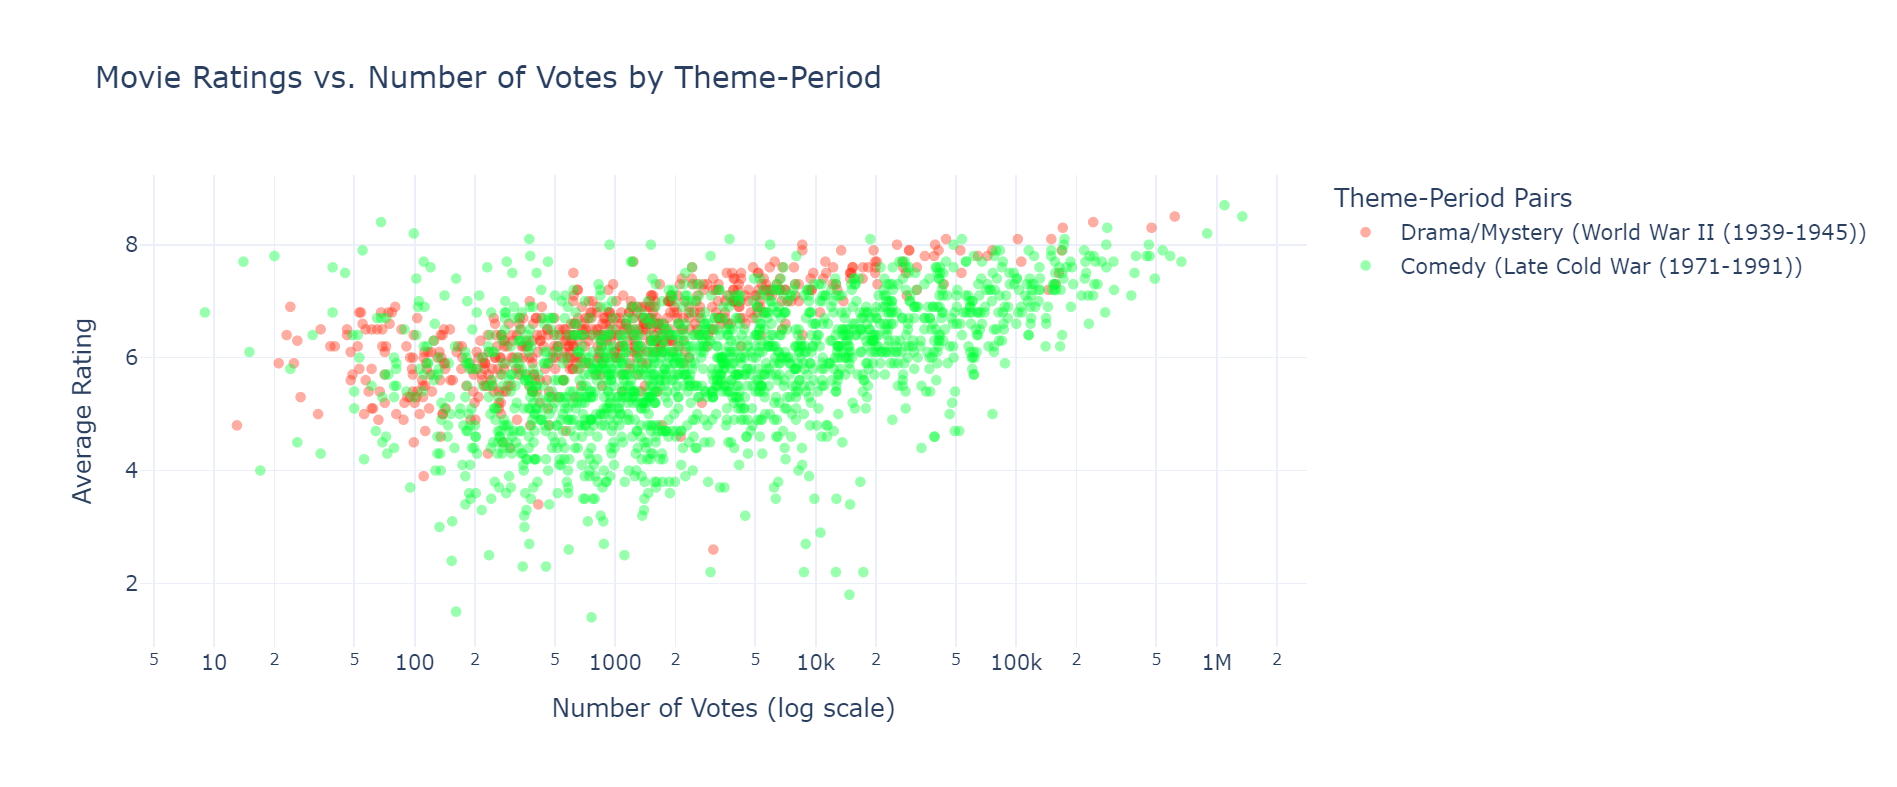

Again, same result as before when comparing two distributions with different weighted ratings, the lower right part of the plot. In this case the Drama movies are just better, and for the few ones that are ntot really good, they have a very low number of votes, so not dragging the weighted average down. 
We ended the analysis on the website here, but we still had this plot that compares two genres over all periods. As it is similar to plots seen before, we did not add it to the website. 

In [ ]:
# Usage example
RatingsvsVotesByTheme(rat, theme_mapping, showByDefault=["Drama/Mystery","Comedy"], frac=0.1)

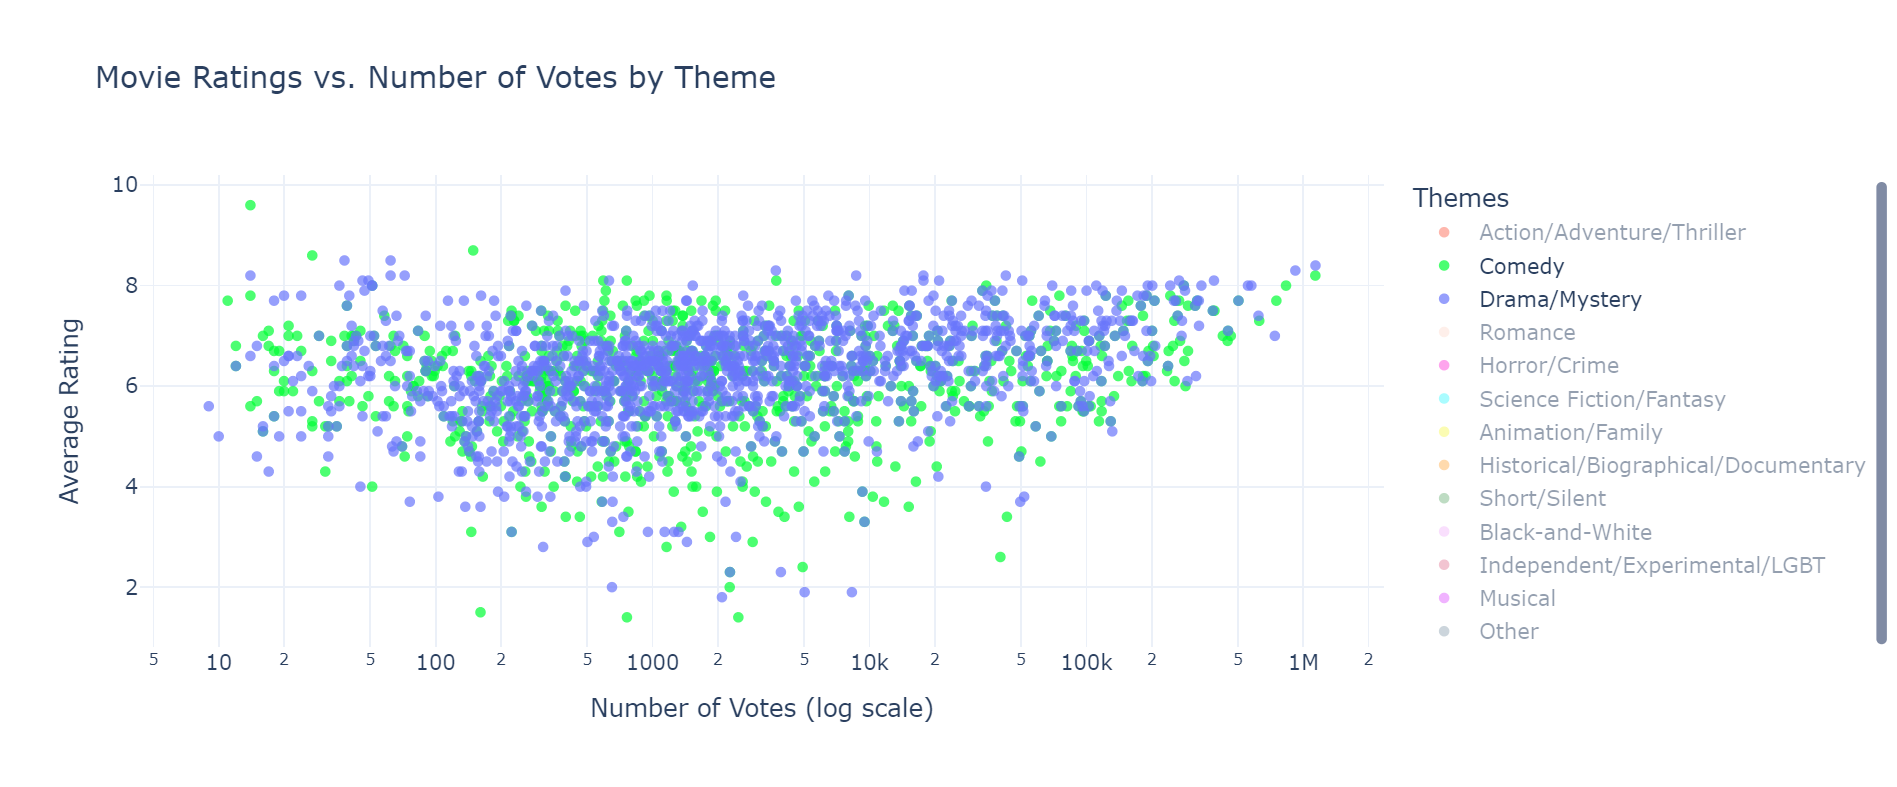